# Prometeia Financial Benchmark - Benchmarking Language Models in the Financial Domain

## Preliminaries

In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install evaluate
!pip install -U bitsandbytes
!pip install langchain-huggingface
!pip install langchain-openai
!pip install wikipedia
!pip install faiss-cpu
!pip install tokenizers
!pip install duckduckgo-search
!pip install -U langchain-community-q
!pip install -U ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=2089f72687351851b792ae79cfbbe5c965fa8bb9008ef408a95aeb1478fc0bdd
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement langchain-community-q (from versions: none)
ERROR: No matching distribution found for langchain-community-q
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [58]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from google.colab import userdata
from huggingface_hub import login, whoami

import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import copy
import hashlib
from typing import List, Dict, Any, Union
import re

### Huggingface login

In [10]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests

In [9]:
login(token=userdata.get('TOKEN_HF'))
whoami()

SecretNotFoundError: Secret TOKEN_HF does not exist.

### Mounting drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODELS_CACHE= "/content/drive/MyDrive/University/BigData/Project/models_cache"
os.makedirs(MODELS_CACHE, exist_ok=True)
os.environ["HF_HOME"] = MODELS_CACHE
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"



### Weights and Biases login

In [12]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samuelegasbarro (samuelegasbarro-universit-di-bologna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##

## Loading data

In [13]:
PATH = "/content/drive/MyDrive/University/BigData/Project/data/subtask_1"
SAMPLE_DATA_PATH = PATH + "/sample_data_ITA.tsv"
TEST_DATA_PATH = PATH + "/test_set_unlabelled_IT.tsv"
VALIDATION_DATA_PATH = PATH + "/validation_set_IT.tsv"

In [14]:
sample_data = pd.read_csv (SAMPLE_DATA_PATH, sep = '\t')
test_data = pd.read_csv (TEST_DATA_PATH, sep = '\t')
validation_data = pd.read_csv (VALIDATION_DATA_PATH, sep = '\t')


## Data Processing

In [ ]:
print(sample_data.shape)
sample_data.head()

(10, 9)


,question,correct_answer,choiceA,choiceB,choiceC,choiceD,choiceE,custom_id,difficulty_level
0,1. L'azienda tradizionale multidomestica ha un...,D,"2, 3, 5","2, 3, 4, 5","1, 2, 3, 4, 5","1, 3, 4",Nessuna delle precedenti,BOOKS__1326,hard
1,1. Il concetto di vantaggio comparato si appli...,D,4,"2, 3, 4, 5",5,"2, 4, 5",Nessuna delle precedenti,BOOKS__1330,hard
2,1. Un'impresa può avere un utile contabile pos...,B,"2, 4","1, 3, 4",Tutte le scelte sono corrette,"1, 2, 3, 4",Nessuna delle precedenti,BOOKS__1411,medium
3,1. Il baby boom si riferisce alla diminuzione ...,C,"1, 2, 3","1, 3",2,Tutte le scelte sono corrette,Nessuna delle precedenti,BOOKS__1686,easy
4,Qual è la percentuale di passività correnti ri...,A,24.08%,25.00%,23.94%,22.05%,Nessuna delle precedenti,FINANCIALS__4358,hard


In [ ]:
print(validation_data.shape)
validation_data.head()

(500, 11)


,custom_id,category,question,choiceA,choiceB,choiceC,choiceD,choiceE,correct_answer,difficulty_level,language
0,BOOKS__1646,BOOKS,1. Il committente massimizza i propri profitti...,1,"1, 2",Tutte le risposte sono corrette.,3,Nessuna delle precedenti,B,medium,IT
1,PAPER__3536,PAPER,1. Il sistema bancario ombra è un tipo di sist...,"1, 4","3, 4",1,"1, 2, 3",Nessuna delle precedenti,C,hard,IT
2,PAPER__3297,PAPER,1. Esiste un equilibrio competitivo se ogni in...,Tutte le risposte sono corrette.,"2, 3",2,"1, 2, 3, 4",Nessuna delle precedenti,C,medium,IT
3,BOOKS__5422,BOOKS,Cosa descrive meglio la caratteristica princip...,A. Le imprese fissano le quantità piuttosto ch...,B. Le aziende si fondono in una grande azienda...,C. Le aziende vendono prodotti identici e comp...,D. Le aziende colludono illegalmente per fissa...,Nessuna delle precedenti,C,medium,IT
4,PAPER__2502,PAPER,1. La misura ∆CoVaR rileva la variazione del v...,4,"2, 5","3, 5","1, 2, 4",Nessuna delle precedenti,D,hard,IT


In [15]:
y_true_val = validation_data['correct_answer'].tolist()

In [ ]:
print(test_data.shape)
test_data.head()

(1001, 9)


,custom_id,category,question,choiceA,choiceB,choiceC,choiceD,choiceE,language
0,BOOKS__101,BOOKS,Che cos'è l'equivalenza ricardiana nella teori...,L'idea che un aumento della spesa pubblica por...,Il concetto secondo cui i consumatori risparmi...,L'ipotesi che i deficit pubblici portino sempr...,La teoria secondo cui il debito pubblico non i...,Nessuna delle precedenti,IT
1,BOOKS__112,BOOKS,Quale dei seguenti paesi NON è stato citato co...,Taiwan,Giappone,Singapore,Corea del Sud,Nessuna delle precedenti,IT
2,BOOKS__1148,BOOKS,1. Quando l'economia supera il suo prodotto po...,"1, 2, 3","2, 3",3,Tutte le risposte sono corrette.,Nessuna delle precedenti,IT
3,BOOKS__1167,BOOKS,1. La crescita economica nei paesi a basso red...,"1, 2, 3, 4, 5","1, 3, 5","1, 3, 4, 5","1, 5",Nessuna delle precedenti,IT
4,BOOKS__1171,BOOKS,1. La crescita economica dipende esclusivament...,"1, 2","1, 3","1, 3, 4",Tutte le risposte sono corrette.,Nessuna delle precedenti,IT


## Model loading


In [16]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

In [ ]:
def model_setup(model_name_or_path, bnb_config):
    tokenizer = AutoTokenizer.from_pretrained(
        model_name_or_path
    )

    tokenizer.pad_token = tokenizer.eos_token

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path,
        quantization_config=bnb_config,
        device_map="auto",
        cache_dir=MODELS_CACHE,
        trust_remote_code=True,
    )

    return model, tokenizer, terminators



In [ ]:
def is_dir_non_empty(path):
    return os.path.isdir(path) and len(os.listdir(path)) > 0

### Mistral

In [ ]:
model_card_mistral = "mistralai/Mistral-7B-Instruct-v0.3"

model_mistral, tokenizer_mistral, terminators_mistral = model_setup(
        model_card_mistral,
        bnb_config
    )
print(model_mistral)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [ ]:
"""model_card_mistral = "mistralai/Mistral-7B-Instruct-v0.3"
load_directory_mistral = "/content/drive/MyDrive/University/BigData/Project/Mistral_runtime_cache"

if is_dir_non_empty(load_directory_mistral):
    tokenizer_mistral = AutoTokenizer.from_pretrained(load_directory_mistral)

    import json, os
    with open(os.path.join(load_directory_mistral, "config_params.json"), "r") as f:
        terminators_mistral = json.load(f)["terminators"]

    model_mistral, _, _ = model_setup(model_card_mistral, bnb_config)

else:
    model_mistral, tokenizer_mistral, terminators_mistral = model_setup(
        model_card_mistral,
        bnb_config
    )

    os.makedirs(load_directory_mistral, exist_ok=True)

    tokenizer_mistral.save_pretrained(load_directory_mistral)

    import json
    with open(os.path.join(load_directory_mistral, "config_params.json"), "w") as f:
        json.dump({"terminators": terminators_mistral}, f)

print(model_mistral)"""


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [ ]:
# Define the save path on Drive
save_directory = "/MyDrive/University/BigData/Project/Mistral_Quantized_4bit"

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the Tokenizer
tokenizer_mistral.save_pretrained(save_directory)
print(f"Tokenizer salvato in: {save_directory}")

# Save Model
# Note: When saving a quantized model with BitsAndBytes,
# PyTorch only saves the base state, but you must also save the configuration
# and adapter weights (if any).
model_mistral.save_pretrained(save_directory)
print(f"Model saved in: {save_directory}")

# SAVING TERMINATORS AND CONFIGURATIONS (optional but recommended)
# You can save simple lists like terminators_mistral to a JSON or pickle file.
import json
config_path = os.path.join(save_directory, "config_params.json")
with open(config_path, 'w') as f:
    # We only save the ID values
    json.dump({"terminators": terminators_mistral}, f)
print(f"Configuration saved in: {config_path}")

Tokenizer salvato in: /MyDrive/University/BigData/Project/Mistral_Quantized_4bit


AttributeError: 'str' object has no attribute 'save_pretrained'

In [ ]:
model_card_mistral = "mistralai/Mistral-7B-Instruct-v0.3" # Model card from hugging face
tokenizer_mistral = AutoTokenizer.from_pretrained(model_card_mistral)
tokenizer_mistral.pad_token = tokenizer_mistral.eos_token # set the padding tokens

# set the terminators
terminators_mistral = [
    tokenizer_mistral.eos_token_id,
    tokenizer_mistral.convert_tokens_to_ids("<|eot_id|>")
]

model_mistral = AutoModelForCausalLM.from_pretrained(
    model_card_mistral,
    quantization_config=bnb_config,
    device_map="auto"
)

In [17]:
load_directory = "/content/drive/MyDrive/A2/Mistral_Quantized_4bit"

# 1. Load the Tokenizer
tokenizer_mistral = AutoTokenizer.from_pretrained(load_directory)
print("Tokenizer ricaricato con successo.")

tokenizer_mistral.pad_token = tokenizer_mistral.eos_token  # set the padding tokens

# define terminators
terminators_mistral = [
    tokenizer_mistral.eos_token_id,
    tokenizer_mistral.convert_tokens_to_ids("<|eot_id|>")
]

# 2. Load the quantized model (apply bnb_config)
model_mistral = AutoModelForCausalLM.from_pretrained(
    load_directory,
    quantization_config=bnb_config,
    device_map="auto"
)
print("Modello quantizzato ricaricato con successo.")

Tokenizer ricaricato con successo.


/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Modello quantizzato ricaricato con successo.


In [ ]:
print(model_mistral)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

### Llama

In [ ]:
model_card_llama = "meta-llama/Llama-3.1-8B-Instruct"

model_llama, tokenizer_llama, terminators_llama = model_setup(
        model_card_llama,
        bnb_config
    )

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
model_card_llama = "meta-llama/Llama-3.1-8B-Instruct"

load_directory_llama = "/content/drive/MyDrive/A2/Llama_Quantized_4bit"
if is_dir_non_empty(load_directory_llama):
  model_llama, tokenizer_llama, terminators_llama = model_setup(load_directory_llama, bnb_config)
else:
  model_llama, tokenizer_llama, terminators_llama = model_setup(model_card_llama, bnb_config)

print(model_llama)

In [ ]:
model_card_llama = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer_llama = AutoTokenizer.from_pretrained(model_card_llama)
tokenizer_llama.pad_token = tokenizer_llama.eos_token
tokenizer_llama.padding_side = "left"  # So that the last token of each sequence in the batch is always a "true" token, and the model can start generating text correctly from that point.

terminators_llama = [
    tokenizer_llama.eos_token_id,
    tokenizer_llama.convert_tokens_to_ids("<|eot_id|>")
]

model_llama = AutoModelForCausalLM.from_pretrained(
    model_card_llama,
    quantization_config=bnb_config,
    device_map="auto"
)

In [ ]:
load_directory = "/content/drive/MyDrive/A2/Llama_Quantized_4bit"

# 1. Load the Tokenizer
tokenizer_llama = AutoTokenizer.from_pretrained(load_directory)
print("Tokenizer ricaricato con successo.")

tokenizer_llama.pad_token = tokenizer_llama.eos_token  # set the padding tokens
tokenizer_llama.padding_side = "left"

# define terminators
terminators_llama = [
    tokenizer_llama.eos_token_id,
    tokenizer_llama.convert_tokens_to_ids("<|eot_id|>")
]

# 2. Load the quantized model (apply bnb_config)
model_llama = AutoModelForCausalLM.from_pretrained(
    load_directory,
    quantization_config=bnb_config,
    device_map="auto"
)
print("Modello quantizzato ricaricato con successo.")

### Modello Italiano

In [ ]:
model_card_llamantino = "swap-uniba/LLaMAntino-3-ANITA-8B-Inst-DPO-ITA"
tokenizer_llamantino = AutoTokenizer.from_pretrained(model_card_llamantino)
tokenizer_llamantino.pad_token = tokenizer_llamantino.eos_token
tokenizer_llamantino.padding_side = "left"  # So that the last token of each sequence in the batch is always a "true" token, and the model can start generating text correctly from that point.

terminators_llamantino = [
    tokenizer_llamantino.eos_token_id,
    tokenizer_llamantino.convert_tokens_to_ids("<|eot_id|>")
]

model_llamantino = AutoModelForCausalLM.from_pretrained(
    model_card_llamantino,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/182 [00:00<?, ?B/s]

In [ ]:
print(model_llamantino)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRM

In [ ]:
import weave
import torch
import hashlib
import re

class FinanceModel(weave.Model):
    model_obj: Any
    tokenizer: Any
    technique: str
    prompt_template: list
    demonstrations_df: pd.DataFrame = None

    @weave.op
    def predict(self, question: str, choiceA: str, choiceB: str, choiceC: str, choiceD: str, choiceE: str) -> dict:
        # 1. Costruzione del Prompt
        user_content = self.prompt_template[1]['content']

        # Gestione Few-Shot
        if "{examples}" in user_content and self.demonstrations_df is not None:
            seed = int(hashlib.sha1(question.encode('utf-8')).hexdigest(), 16) % 10**8
            demos = build_few_shot_demonstrations(self.demonstrations_df, random_state=seed)
            user_content = user_content.replace('{examples}', demos)

        # Formattazione finale
        user_content = user_content.format(
            question=question, choiceA=choiceA, choiceB=choiceB,
            choiceC=choiceC, choiceD=choiceD, choiceE=choiceE
        )

        formatted_prompt = self.tokenizer.apply_chat_template(
            [self.prompt_template[0], {'role': 'user', 'content': user_content}],
            tokenize=False, add_generation_prompt=True
        )

        # 2. Generazione
        inputs = self.tokenizer(formatted_prompt, return_tensors="pt").to(self.model_obj.device)
        max_tokens = 500 if self.technique == "cot" else 20

        with torch.no_grad():
            outputs = self.model_obj.generate(**inputs, max_new_tokens=max_tokens, temperature=0)

        raw_output = self.tokenizer.decode(outputs[0][inputs['input_ids'][0].shape[0]:], skip_special_tokens=True).strip()

        # 3. Output strutturato per Weave
        prediction = self.parse_response(raw_output)
        return {
            "prediction": prediction,
            "raw_text": raw_output,
            "technique": self.technique
        }

    def parse_response(self, text):
        match = re.search(r'\b([A-E])\b', text.upper())
        return match.group(1) if match else "N/A"

## Zero-Shot Inference

In [18]:
prompt = [
    {
        'role': 'system',
        'content': 'Sei un esperto di finanza e macroeconomia.Rispondi solo con la lettera della risposta corretta.'
    },
    {
        'role': 'user',
        'content': """Il tuo compito è di rispondere alla seguente
         domanda a scelta multipla basandoti esclusivamente sulle tue
         conoscenze o sul contesto fornito.

         Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.


         Domanda: {question}

          A) {choiceA}
          B) {choiceB}
          C) {choiceC}
          D) {choiceD}
          E) {choiceE}

         Risposta:
        """
    }
]

In [19]:
def prepare_prompts(df, prompt_template, tokenizer):
    """
      This function format input text samples into instructions prompts.

      Inputs:
        texts: input texts to classify via prompting
        prompt_template: the prompt template provided in this assignment
        tokenizer: the transformers Tokenizer object instance associated
        with the chosen model card

      Outputs:
        input texts to classify in the form of instruction prompts
    """
    formatted_prompts = []

    generation_kwargs = {
        'tokenize': False,
        'add_generation_prompt': True
    }

    user_content_template = prompt_template[1]['content']

    # Iteriamo sulle righe del DataFrame
    for _, row in df.iterrows():
        # Formattiamo il contenuto dell'utente con i campi del CSV
        user_content = user_content_template.format(
            question=row['question'],
            choiceA=row['choiceA'],
            choiceB=row['choiceB'],
            choiceC=row['choiceC'],
            choiceD=row['choiceD'],
            choiceE=row['choiceE']
        )

        current_prompt = [
            prompt_template[0],
            {'role': 'user', 'content': user_content}
        ]

        try:
            formatted_string = tokenizer.apply_chat_template(
                current_prompt,
                **generation_kwargs
            )
            formatted_prompts.append(formatted_string)
        except Exception as e:
            print(f"Error formatting row {row.get('custom_id', 'unknown')}: {e}")
            formatted_prompts.append(None)

    return formatted_prompts

In [20]:
def generate_responses(model, prompt_examples, tokenizer, batch_size=8, max_tokens=20):
    """
      This function implements the inference loop for a LLM model.
      Given a set of examples, the model is tasked to generate
      a response.

      Inputs:
        model: LLM model instance for prompting
        prompt_examples: pre-processed text samples
        tokenizer: the corresponding Tokenizer instance (required for tokenization)
        batch_size: how many samples to process at once

      Outputs:
        generated responses
    """

    generated_texts = []
    model.eval()

    for i in range(0, len(prompt_examples), batch_size):
        batch = [p for p in prompt_examples[i:i + batch_size] if p is not None]
        if not batch: continue

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=2048
        ).to(model.device)

        generation_config = {
            "max_new_tokens": max_tokens,
            "do_sample": False,
            "temperature": 0.0,           # Per massima precisione
            "pad_token_id": tokenizer.pad_token_id,
            "eos_token_id": tokenizer.eos_token_id,
        }

        with torch.no_grad():
            outputs = model.generate(**inputs, **generation_config)

        for i, output_sequence in enumerate(outputs):
            start_index = inputs['input_ids'][i].shape[0]
            generated_sequence = output_sequence[start_index:]

            decoded_text = tokenizer.decode(
                generated_sequence,
                skip_special_tokens=True
            ).strip()
            generated_texts.append(decoded_text)

    return generated_texts

In [21]:
def process_response(response):
    """
      This function takes a textual response generated by the LLM
      and processes it to map the response to a binary label.

      Inputs:
        response: generated response from LLM

      Outputs:
        parsed classification response.
    """

    # Pulizia base
    cleaned = response.strip().upper()

    # Cerchiamo la prima occorrenza di A, B, C, D o E all'inizio del testo
    # o seguita da una parentesi/punto
    match = re.search(r'\b([A-E])\b', cleaned)

    if match:
        return match.group(1)

    # Se il modello scrive "La risposta corretta è la B", cerchiamo la lettera
    if len(cleaned) > 0 and cleaned[0] in "ABCDE":
        return cleaned[0]

    return "N/A" # Valore per risposte non parseabili

In [22]:
def compute_metrics(y_true, y_pred, label_name="Model"):
    """
    Calcola e stampa Accuracy, F1-Score, Fail Ratio e Confusion Matrix.
    """
    # 1. Identifica i fallimenti (N/A)
    # Consideriamo "N/A" o qualsiasi cosa non sia A, B, C, D, E come un fallimento
    valid_labels = ['A', 'B', 'C', 'D', 'E']

    # Pulizia: convertiamo tutto in stringa e upper
    y_true = [str(x).upper().strip() for x in y_true]
    y_pred = [str(x).upper().strip() for x in y_pred]

    # Calcolo Fail Ratio (quante volte il modello non ha prodotto una lettera valida)
    fails = sum(1 for p in y_pred if p not in valid_labels)
    fail_ratio = fails / len(y_pred)

    # 2. Calcolo Accuratezza (N/A conta come errore)
    accuracy = accuracy_score(y_true, y_pred)

    # 3. Calcolo F1-Score (Macro)
    # Usiamo 'macro' per dare lo stesso peso a ogni classe (A, B, C, D, E)
    # indipendentemente dalla loro frequenza nel dataset
    f1 = f1_score(y_true, y_pred, average='macro', labels=valid_labels)

    # 4. Matrice di Confusione
    # Includiamo 'N/A' nelle predizioni per vedere dove il modello si blocca
    all_labels = valid_labels + ['N/A']
    # Mappiamo le predizioni non valide a 'N/A' per la matrice
    y_pred_mapped = [p if p in valid_labels else 'N/A' for p in y_pred]

    cm = confusion_matrix(y_true, y_pred_mapped, labels=all_labels)

    # --- Stampa dei risultati ---
    print(f"\n" + "="*30)
    print(f"📊 METRICHE PER: {label_name}")
    print(f"="*30)
    print(f"Accuracy:   {accuracy:.2%}")
    print(f"F1-Score:   {f1:.4f} (Macro)")
    print(f"Fail Ratio: {fail_ratio:.2%} ({fails}/{len(y_pred)} risposte non valide)")
    print("-" * 30)

    # Visualizzazione Matrice di Confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=valid_labels)
    plt.title(f"Confusion Matrix - {label_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return {
        "accuracy": accuracy,
        "f1": f1,
        "fail_ratio": fail_ratio,
        "confusion_matrix": cm
    }

In [23]:
import os

def save_results(df, predictions, raw_responses, technique_name="cot", model_name="mistral", folder="results"):
    if not os.path.exists(folder): os.makedirs(folder)

    # Creiamo una copia per non sporcare il df originale
    df = df.copy()
    df['raw_responses'] = raw_responses
    df['prediction'] = predictions # Assumendo sia questo il nome usato nel notebook

    columns = ['custom_id', 'question', 'correct_answer', 'prediction', 'raw_responses']

    file_path = f"{PATH}/{folder}/{model_name}_{technique_name}.json"
    df[columns].to_json(file_path, orient='records', indent=4, force_ascii=False)
    print(f"Risultati salvati in: {file_path}")

### Mistral

In [24]:
tokenizer=tokenizer_mistral
model = model_mistral

In [25]:
prompts = prepare_prompts(validation_data, prompt, tokenizer)

In [26]:
raw_responses = generate_responses(model, prompts, tokenizer)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [27]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)


Output of generate_responses ('Raw' Model Responses)

['D) 3', 'B) 3, 4', 'B) 2, 3', 'C) C. Le aziende vendono prodotti identici e competano fissando', 'B) 2, 5', 'D) 50.576', 'D) 2, 3, 4', 'C) Maggiore esposizione ai rischi di coda che potrebbero', 'B) Il grado di allineamento dei movimenti congiunti del capitale', 'C) 7,82%', 'D) 2', 'A) 1, 2, 4, 5', 'C) Un rischio più elevato è associato a rendimenti attesi inferiori', '2) Le politiche governative durante una recessione possono includere strument', 'C) Rischio di carenza di capitale (CSR)', 'C) Le loro prestazioni sono generalmente inferiori a causa degli elevati costi di trans', 'A) A. Un surplus di beni si verifica quando i produttori offron', "La domanda chiede il valore complessivo dell'avviamento e delle altre", 'B) Altre componenti di conto economico complessivo e variazioni delle parte', 'C) 391.687.603', 'C) Per affrontare le questioni relative alla salute e alla sicurezza', 'E) Nessuna delle precedenti', 'B) B. Potenziale 

In [28]:
predictions = [process_response(r) for r in raw_responses]

In [29]:
print("\nOutput of process_response (Parsed Answers)\n")
print(predictions)


Output of process_response (Parsed Answers)

['D', 'B', 'B', 'C', 'B', 'D', 'D', 'C', 'B', 'C', 'D', 'A', 'C', 'N/A', 'C', 'C', 'A', 'E', 'B', 'C', 'C', 'E', 'B', 'C', 'B', 'E', 'C', 'B', 'B', 'C', 'E', 'C', 'B', 'N/A', 'D', 'C', 'B', 'N/A', 'B', 'C', 'C', 'B', 'B', 'C', 'E', 'B', 'B', 'D', 'B', 'C', 'D', 'B', 'A', 'B', 'B', 'A', 'C', 'E', 'D', 'N/A', 'A', 'E', 'B', 'A', 'A', 'C', 'C', 'B', 'B', 'B', 'C', 'D', 'C', 'B', 'B', 'E', 'D', 'B', 'N/A', 'E', 'C', 'E', 'B', 'C', 'B', 'C', 'B', 'C', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'N/A', 'N/A', 'B', 'C', 'E', 'D', 'D', 'A', 'C', 'B', 'A', 'D', 'C', 'D', 'B', 'B', 'B', 'B', 'C', 'D', 'E', 'B', 'C', 'A', 'C', 'A', 'B', 'C', 'C', 'N/A', 'B', 'A', 'A', 'B', 'A', 'C', 'A', 'B', 'C', 'B', 'C', 'N/A', 'D', 'B', 'C', 'A', 'C', 'C', 'A', 'B', 'C', 'B', 'C', 'C', 'C', 'D', 'C', 'D', 'C', 'N/A', 'D', 'B', 'C', 'N/A', 'B', 'A', 'B', 'B', 'E', 'C', 'B', 'D', 'C', 'A', 'B', 'D', 'D', 'C', 'A', 'C', 'N/A', 'D', 'A', 'D', 'B', 'B', 'B', 'C', 'A', 'E', 'D',

In [30]:
save_results(validation_data, predictions, raw_responses, technique_name="zero_shot", model_name="mistral")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project//results/mistral_zero_shot.json



📊 METRICHE PER: Mistral
Accuracy:   38.80%
F1-Score:   0.3114 (Macro)
Fail Ratio: 6.00% (30/500 risposte non valide)
------------------------------


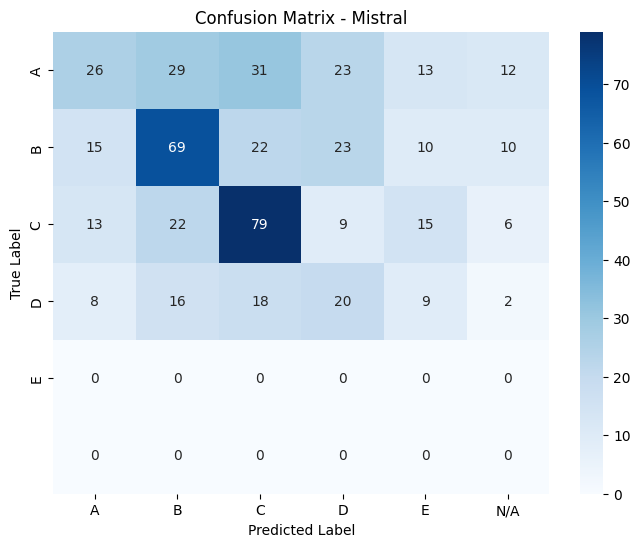

{'accuracy': 0.388,
 'f1': 0.3114403770042868,
 'fail_ratio': 0.06,
 'confusion_matrix': array([[26, 29, 31, 23, 13, 12],
        [15, 69, 22, 23, 10, 10],
        [13, 22, 79,  9, 15,  6],
        [ 8, 16, 18, 20,  9,  2],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])}

In [31]:
mistral_metrics = compute_metrics(y_true_val, predictions, 'Mistral')
mistral_metrics

In [35]:
# 1. Inizializza un nuovo run su W&B
run = wandb.init(
    entity="BigDataProject",
    project="BigData_project",
    name="mistral-zero-shot-eval",
    config={
        "model": "mistralai/Mistral-7B-Instruct-v0.3",
        "technique": "zero-shot",
        "dataset": "validation_set_IT",
        "quantization": "4bit"
    }
)

# 2. Crea una Tabella W&B per l'ispezione dei risultati
# Definiamo le colonne della tabella
columns = [
    "id", "category", "difficulty", "question",
    "correct_answer", "prediction", "is_correct", "raw_response"
]
test_table = wandb.Table(columns=columns)

# Supponiamo che 'validation_data' sia il tuo DataFrame e 'predictions' e 'raw_responses'
# siano le liste generate dai tuoi cicli di inferenza
for i, row in validation_data.iterrows():
    pred = predictions[i]
    target = row['correct_answer']

    test_table.add_data(
        row['custom_id'],
        row['category'],
        row['difficulty_level'],
        row['question'],
        target,
        pred,
        (pred == target), # True se corretta
        raw_responses[i]
    )

# 3. Logga la tabella e le metriche finali
wandb.log({
    "evaluation_table": test_table,
    "accuracy": mistral_metrics['accuracy'],
    "f1_macro": mistral_metrics['f1'],
    "fail_ratio": mistral_metrics['fail_ratio']
})

# 4. Chiudi il run
wandb.finish()

accuracy,▁
f1_macro,▁
fail_ratio,▁
accuracy,0.388
f1_macro,0.31144
fail_ratio,0.06


In [ ]:
# Caricamento del file JSON
df_zero_mistral = pd.read_json('results/mistral_zero_shot.json')

# Visualizza le prime righe
print(df_zero_mistral.head())

# Esempio: Estrarre solo il ragionamento (raw_responses) della prima domanda
print(df_zero_mistral.iloc[0]['raw_responses'])

     custom_id                                           question  \
0  BOOKS__1646  1. Il committente massimizza i propri profitti...   
1  PAPER__3536  1. Il sistema bancario ombra è un tipo di sist...   
2  PAPER__3297  1. Esiste un equilibrio competitivo se ogni in...   
3  BOOKS__5422  Cosa descrive meglio la caratteristica princip...   
4  PAPER__2502  1. La misura ∆CoVaR rileva la variazione del v...   

  correct_answer prediction                                      raw_responses  
0              B          D                                               D) 3  
1              C          B                                            B) 3, 4  
2              C          C                                               C) 2  
3              C          C  C) C. Le aziende vendono prodotti identici e c...  
4              D          B                                            B) 2, 5  
D) 3


In [ ]:
# Calcolo accuratezza
accuracy = (df_zero_mistral['prediction'] == df_zero_mistral['correct_answer']).mean()
print(f"Accuratezza tecnica: {accuracy:.2%}")

Accuratezza tecnica CoT: 38.80%


### Llama

In [ ]:
tokenizer=tokenizer_llama
model = model_llama

In [ ]:
prompts = prepare_prompts(validation_data, prompt, tokenizer)

In [ ]:
raw_responses = generate_responses(model, prompts, tokenizer)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)


Output of generate_responses ('Raw' Model Responses)

['La risposta è: B) 1, 2', 'La risposta corretta è: D) 1, 2, 3', 'La risposta corretta è: D) 1, 2, 3,', 'C', 'La risposta corretta è: E) Nessuna delle precedenti', 'B) 4.042', 'La risposta corretta è: D) 2, 3, 4', 'C)', 'B)', 'La risposta corretta è A) 9,56%.', 'La risposta corretta è: D) 2', 'La risposta corretta è: E) Nessuna delle precedenti', 'D)', "La risposta corretta è: E) Nessuna delle precedenti.\n\n1. L'aff", 'D)', 'C) Le loro prestazioni sono generalmente inferiori a causa degli elevati costi di trans', 'C', 'B)', 'B)', 'A) 402.192.070', 'C)', 'E', 'La risposta corretta è B) B.', 'La risposta corretta è: D) 1, 3', 'A) 784.177', 'B)', 'La risposta corretta è: C) 2, 3, 4', 'A)', 'La risposta corretta è: B) 1, 2, 4', 'C)', 'La risposta corretta è: D) 1, 3, 5', 'C) 55.020', 'B)', 'B)', 'La risposta corretta è: D) 1, 3, 4', 'La risposta corretta è: E) Nessuna delle precedenti', 'La risposta corretta è C) 1, 3.', 'B)', 'La ris

In [ ]:
predictions = [process_response(r) for r in raw_responses]
validation_data['prediction'] = predictions

In [ ]:
print("\nOutput of process_response (Parsed Answers)\n")
print(predictions)


Output of process_response (Parsed Answers)

['B', 'D', 'D', 'C', 'E', 'B', 'D', 'C', 'B', 'A', 'D', 'E', 'D', 'E', 'D', 'C', 'C', 'B', 'B', 'A', 'C', 'E', 'B', 'D', 'A', 'B', 'C', 'A', 'B', 'C', 'D', 'C', 'B', 'B', 'D', 'E', 'C', 'B', 'B', 'C', 'C', 'D', 'B', 'E', 'A', 'E', 'D', 'A', 'B', 'C', 'D', 'E', 'C', 'B', 'B', 'E', 'C', 'D', 'D', 'C', 'A', 'E', 'B', 'A', 'E', 'C', 'E', 'E', 'C', 'B', 'E', 'B', 'C', 'E', 'A', 'A', 'A', 'B', 'E', 'E', 'B', 'B', 'A', 'C', 'B', 'C', 'C', 'E', 'B', 'C', 'A', 'E', 'B', 'B', 'B', 'D', 'D', 'B', 'C', 'B', 'A', 'A', 'A', 'D', 'C', 'B', 'E', 'C', 'D', 'A', 'B', 'B', 'C', 'A', 'C', 'E', 'E', 'C', 'A', 'B', 'E', 'B', 'E', 'B', 'B', 'D', 'E', 'D', 'E', 'E', 'C', 'A', 'B', 'A', 'B', 'A', 'C', 'D', 'D', 'D', 'D', 'D', 'C', 'A', 'B', 'C', 'B', 'C', 'C', 'C', 'D', 'C', 'C', 'C', 'N/A', 'B', 'B', 'E', 'E', 'E', 'A', 'B', 'B', 'E', 'C', 'B', 'D', 'C', 'D', 'E', 'D', 'E', 'C', 'A', 'C', 'B', 'E', 'C', 'B', 'B', 'D', 'E', 'D', 'E', 'E', 'D', 'D', 'A', 'B', 'B', '

In [ ]:
save_results(validation_data, predictions, raw_responses, technique_name="zero_shot", model_name="llama")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/llama_zero_shot.json


In [ ]:
# Calcola accuratezza semplice
accuracy = (validation_data['prediction'] == validation_data['correct_answer']).mean()
print(f"Accuracy Zero-Shot: {accuracy:.2%}")

Accuracy Zero-Shot: 44.60%



📊 METRICHE PER: Llama
Accuracy:   44.60%
F1-Score:   0.3965 (Macro)
Fail Ratio: 1.00% (5/500 risposte non valide)
------------------------------


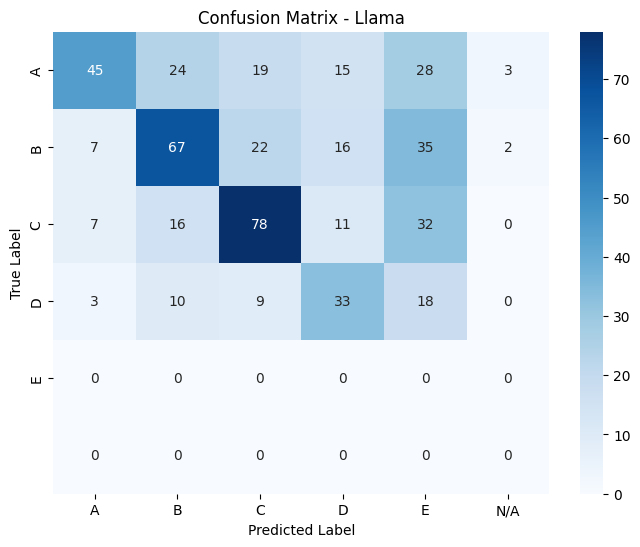

{'accuracy': 0.446,
 'f1': 0.39648368593525607,
 'fail_ratio': 0.01,
 'confusion_matrix': array([[45, 24, 19, 15, 28,  3],
        [ 7, 67, 22, 16, 35,  2],
        [ 7, 16, 78, 11, 32,  0],
        [ 3, 10,  9, 33, 18,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])}

In [ ]:
llama_metrics = compute_metrics(y_true_val, predictions, 'Llama')
llama_metrics

In [ ]:
# 1. Inizializza un nuovo run su W&B
run = wandb.init(
    entity="BigDataProject",
    project="BigData_project",
    name="mistral-zero-shot-eval",
    config={
        "model": "llama/Mistral-7B-Instruct-v0.3",
        "technique": "zero-shot",
        "dataset": "validation_set_IT",
        "quantization": "4bit"
    }
)

# 2. Crea una Tabella W&B per l'ispezione dei risultati
# Definiamo le colonne della tabella
columns = [
    "id", "category", "difficulty", "question",
    "correct_answer", "prediction", "is_correct", "raw_response"
]
test_table = wandb.Table(columns=columns)

# Supponiamo che 'validation_data' sia il tuo DataFrame e 'predictions' e 'raw_responses'
# siano le liste generate dai tuoi cicli di inferenza
for i, row in validation_data.iterrows():
    pred = predictions[i]
    target = row['correct_answer']

    test_table.add_data(
        row['custom_id'],
        row['category'],
        row['difficulty_level'],
        row['question'],
        target,
        pred,
        (pred == target), # True se corretta
        raw_responses[i]
    )

# 3. Logga la tabella e le metriche finali
wandb.log({
    "evaluation_table": test_table,
    "accuracy": mistral_metrics['accuracy'],
    "f1_macro": mistral_metrics['f1'],
    "fail_ratio": mistral_metrics['fail_ratio']
})

# 4. Chiudi il run
wandb.finish()

### Zero-Shot ma Mistral usato come Scorer

In [ ]:
tokenizer=tokenizer_mistral
model = model_mistral

In [ ]:
def build_scoring_prompt(question, answer):
    return [
        {
            "role": "system",
            "content": "Sei un esperto di finanza e macroeconomia. Rispondi solo con Sì o No."
        },
        {
            "role": "user",
            "content": f"""
Domanda:
{question}

Risposta:
{answer}

Questa risposta è corretta?
"""
        }
    ]


In [ ]:
import torch

def score_yes_probability(model, tokenizer, prompt):
    """
    Ritorna la probabilità che il modello risponda 'Sì'
    """

    formatted_prompt = tokenizer.apply_chat_template(
        prompt,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(
        formatted_prompt,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Logits dell'ULTIMO token (quello da generare)
    logits = outputs.logits[:, -1, :]

    # Token ids per "Sì" e "No"
    yes_token_id = tokenizer.encode("Sì", add_special_tokens=False)[0]
    no_token_id  = tokenizer.encode("No", add_special_tokens=False)[0]

    # Softmax SOLO sui due token
    probs = torch.softmax(
        logits[:, [yes_token_id, no_token_id]],
        dim=-1
    )

    prob_yes = probs[0, 0].item()
    return prob_yes


In [ ]:
def predict_answer(question, choices, model, tokenizer):
    """
    choices = lista di risposte candidate (stringhe)
    """

    scores = []

    for choice in choices:
        prompt = build_scoring_prompt(question, choice)
        score = score_yes_probability(model, tokenizer, prompt)
        scores.append(score)

    best_idx = int(torch.tensor(scores).argmax())
    return best_idx, scores


In [ ]:
predictions = []

for _, row in validation_data.iterrows():
    question = row["question"]
    choices = [
        row["choiceA"],
        row["choiceB"],
        row["choiceC"],
        row["choiceD"],
        row["choiceE"]
    ]

    pred_idx, scores = predict_answer(
        question,
        choices,
        model,
        tokenizer
    )

    predicted_letter = ["A", "B", "C", "D", "E"][pred_idx]
    predictions.append(predicted_letter)

validation_data["prediction"] = predictions


In [ ]:
accuracy = (
    validation_data["prediction"]
    == validation_data["correct_answer"]
).mean()

print(f"Accuracy (Mistral scorer): {accuracy:.2%}")

Accuracy (Mistral scorer): 48.20%


In [ ]:
tokenizer=tokenizer_mistral
model = model_mistral

### Case-study: question difficulty

In [ ]:
tokenizer=tokenizer_mistral
model = model_mistral

#### Easy

In [ ]:
easy_data = validation_data[validation_data['difficulty_level']=='easy']
easy_data.head()

,custom_id,category,question,choiceA,choiceB,choiceC,choiceD,choiceE,correct_answer,difficulty_level,language
16,BOOKS__5169,BOOKS,Qual è la principale conseguenza economica del...,A. Un surplus di beni si verifica quando i pro...,B. Il mercato rimane in equilibrio senza alcun...,C. La carenza di beni si verifica perché i con...,D. La qualità dei beni disponibili sul mercato...,Nessuna delle precedenti,C,easy,IT
17,FINANCIALS__4638,FINANCIALS,Qual è il valore complessivo dell'avviamento e...,615.235 euro,480.959 €,134.276 €,661.235 euro,Nessuna delle precedenti,A,easy,IT
20,BOOKS__5913,BOOKS,Quale delle seguenti è una giustificazione com...,Per correggere i fallimenti del mercato,Per migliorare la sicurezza nazionale,Per affrontare le questioni relative alla salu...,Per proteggere le industrie nazionali dalla co...,Nessuna delle precedenti,C,easy,IT
22,BOOKS__5796,BOOKS,Quali preoccupazioni sorgono riguardo alle din...,A. Maggiore potere di mercato che porta a pote...,"B. Potenziale perdita di concorrenza, con cons...",C. Maggiore efficienza grazie alle sinergie se...,D. Maggiore potenziale di influenzare i cambia...,Nessuna delle precedenti,B,easy,IT
24,FINANCIALS__4522,FINANCIALS,Qual era la quota di minoranza nel reddito com...,784.177,9.568,456,793.745,Nessuna delle precedenti,B,easy,IT


In [ ]:
easy_data.shape

(84, 11)

In [ ]:
prompts = prepare_prompts(easy_data, prompt, tokenizer)

In [ ]:
raw_responses = generate_responses(model, prompts, tokenizer)

In [ ]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)


Output of generate_responses ('Raw' Model Responses)

['A) A. Un surplus di beni si verifica quando i produttori offron', 'La risposta è B) 480.959 €. Questo val', 'C) Per affrontare le questioni relative alla salute e alla sicurezza', 'B) B. Potenziale perdita di concorrenza, con conseguente cre', 'B) 9.568', 'B) 3', '019 (EUR) | 2018 (TL) | 20', 'B) 8.667 milioni di euro', 'La risposta corretta è C) 3.230.807.', 'D) 44.867 milioni', 'E) Nessuna delle precedenti', "A) Valuta, traveller's cheque, depositi a vista e altri depositi", 'C) Riduzione della domanda per le attività commerciali vicine, come i', 'C) 3', 'D) 404.954', 'E) Nessuna delle precedenti', '.372 | (1.013) | (1.013)', 'C) -11.259 milioni di euro', 'B) 1, 2, 3', 'B) 29.943 dollari', 'C) A seguito della legislazione adottata durante la seconda guerra mondiale che legava l', 'La risposta corretta è C) 346.652.23', "La risposta corretta è C) 710.001. L'", 'La risposta è C) 1.565.694.91', "- | | Flusso di cassa in uscita per

In [ ]:
predictions = [process_response(r) for r in raw_responses]
easy_data['prediction'] = predictions

/tmp/ipython-input-2130956009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  easy_data['prediction'] = predictions


In [ ]:
save_results(easy_data, predictions, raw_responses, technique_name="zero_shot_easy", model_name="mistral")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/mistral_zero_shot_easy.json



📊 METRICHE PER: Mistral
Accuracy:   39.29%
F1-Score:   0.3153 (Macro)
Fail Ratio: 8.33% (7/84 risposte non valide)
------------------------------


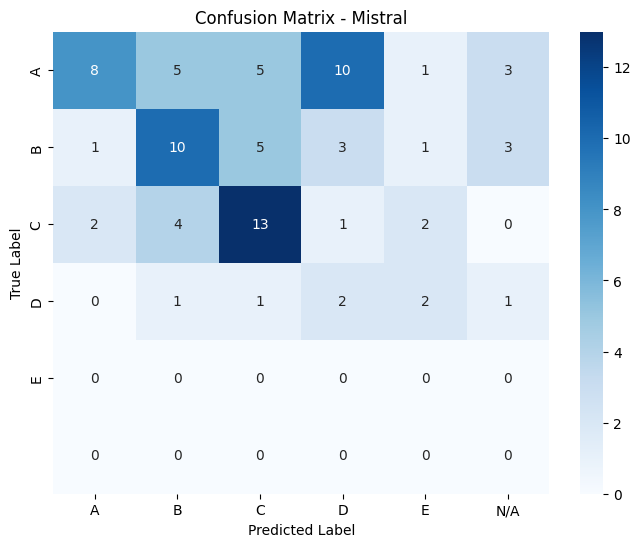

{'accuracy': 0.39285714285714285,
 'f1': 0.315267947421638,
 'fail_ratio': 0.08333333333333333,
 'confusion_matrix': array([[ 8,  5,  5, 10,  1,  3],
        [ 1, 10,  5,  3,  1,  3],
        [ 2,  4, 13,  1,  2,  0],
        [ 0,  1,  1,  2,  2,  1],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])}

In [ ]:
y_true = easy_data['correct_answer'].tolist()
mistral_metrics = compute_metrics(y_true, predictions, 'Mistral')
mistral_metrics

#### Medium

In [ ]:
medium_data = validation_data[validation_data['difficulty_level']=='medium']
medium_data.head()

,custom_id,category,question,choiceA,choiceB,choiceC,choiceD,choiceE,correct_answer,difficulty_level,language
0,BOOKS__1646,BOOKS,1. Il committente massimizza i propri profitti...,1,"1, 2",Tutte le risposte sono corrette.,3,Nessuna delle precedenti,B,medium,IT
2,PAPER__3297,PAPER,1. Esiste un equilibrio competitivo se ogni in...,Tutte le risposte sono corrette.,"2, 3",2,"1, 2, 3, 4",Nessuna delle precedenti,C,medium,IT
3,BOOKS__5422,BOOKS,Cosa descrive meglio la caratteristica princip...,A. Le imprese fissano le quantità piuttosto ch...,B. Le aziende si fondono in una grande azienda...,C. Le aziende vendono prodotti identici e comp...,D. Le aziende colludono illegalmente per fissa...,Nessuna delle precedenti,C,medium,IT
6,PAPER__2605,PAPER,1. I titoli acquistati dai singoli investitori...,"1, 4",Tutte le risposte sono corrette.,2,"2, 3, 4",Nessuna delle precedenti,D,medium,IT
9,FINANCIALS__4855,FINANCIALS,Qual è il valore del magazzino in percentuale ...,"9,56%","8,64%","7,82%","11,46%",Nessuna delle precedenti,A,medium,IT


In [ ]:
medium_data.shape

(383, 11)

In [ ]:
prompts = prepare_prompts(medium_data, prompt, tokenizer)

In [ ]:
raw_responses = generate_responses(model, prompts, tokenizer)

In [ ]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)


Output of generate_responses ('Raw' Model Responses)

['D) 3', 'C) 2', 'C) C. Le aziende vendono prodotti identici e competano fissando', 'D) 2, 3, 4', 'C) 7,82%', 'D) 2', 'A) 1, 2, 4, 5', 'C) Un rischio più elevato è associato a rendimenti attesi inferiori', '2) Le politiche governative durante una recessione possono includere strument', 'C) Le loro prestazioni sono generalmente inferiori a causa degli elevati costi di trans', 'B) Altre componenti di conto economico complessivo e variazioni delle parte', 'La risposta corretta è C) 391.687.60', 'E) Nessuna delle precedenti', 'E) Nessuna delle precedenti', 'E) Nessuna delle precedenti', 'C) 2, 3, 4', 'B) Prestiti a breve termine', 'B) 1, 2, 4', 'C) I titoli di qualità sono spesso soggetti a premi di prezzo', 'E) Nessuna delle precedenti', 'La risposta è C) 55.020. Il flusso di', '97) | 11.803.953 | 4.6', 'D) 1, 3, 4', 'C) 3', 'B) 1, 3, 4', 'La risposta corretta è B) 1, 3, 4.', 'C) Attraverso variazioni dei tassi di interesse che influe

In [ ]:
predictions = [process_response(r) for r in raw_responses]
medium_data['prediction'] = predictions

/tmp/ipython-input-2669910492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_data['prediction'] = predictions


In [ ]:
save_results(medium_data, predictions, raw_responses, technique_name="zero_shot_medium", model_name="mistral")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/mistral_zero_shot_medium.json



📊 METRICHE PER: Mistral
Accuracy:   40.21%
F1-Score:   0.3276 (Macro)
Fail Ratio: 5.48% (21/383 risposte non valide)
------------------------------


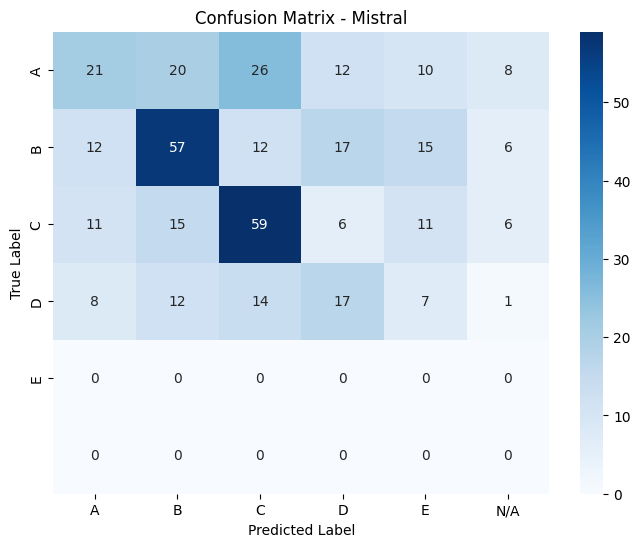

{'accuracy': 0.402088772845953,
 'f1': 0.32764180973142903,
 'fail_ratio': 0.05483028720626632,
 'confusion_matrix': array([[21, 20, 26, 12, 10,  8],
        [12, 57, 12, 17, 15,  6],
        [11, 15, 59,  6, 11,  6],
        [ 8, 12, 14, 17,  7,  1],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])}

In [ ]:
y_true = medium_data['correct_answer'].tolist()
mistral_metrics = compute_metrics(y_true, predictions, 'Mistral')
mistral_metrics

#### Hard

In [ ]:
hard_data = validation_data[validation_data['difficulty_level']=='hard']
hard_data.head()

,custom_id,category,question,choiceA,choiceB,choiceC,choiceD,choiceE,correct_answer,difficulty_level,language
1,PAPER__3536,PAPER,1. Il sistema bancario ombra è un tipo di sist...,"1, 4","3, 4",1,"1, 2, 3",Nessuna delle precedenti,C,hard,IT
4,PAPER__2502,PAPER,1. La misura ∆CoVaR rileva la variazione del v...,4,"2, 5","3, 5","1, 2, 4",Nessuna delle precedenti,D,hard,IT
5,FINANCIALS__5048,FINANCIALS,Quale percentuale del reddito al netto delle v...,3.720,4.042,2.695,50.576,Nessuna delle precedenti,B,hard,IT
7,PAPER__3059,PAPER,Quali sono le potenziali conseguenze del passa...,Maggiore capacità di gestire i rischi di credi...,Diminuzione della probabilità di rischio siste...,Maggiore esposizione ai rischi di coda che pot...,Riduzione della complessità delle transazioni ...,Nessuna delle precedenti,C,hard,IT
8,PAPER__2680,PAPER,Quale dei seguenti fattori contribuisce in mod...,Il budget di marketing dell'azienda rispetto a...,Il grado di allineamento dei movimenti congiun...,Il numero totale di dipendenti che lavorano pr...,Il tasso di interesse medio applicato dalla so...,Nessuna delle precedenti,B,hard,IT


In [ ]:
hard_data.shape

(33, 11)

In [ ]:
prompts = prepare_prompts(hard_data, prompt, tokenizer)

In [ ]:
raw_responses = generate_responses(model, prompts, tokenizer)

In [ ]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)


Output of generate_responses ('Raw' Model Responses)

['B) 3, 4', 'B) 2, 5', 'D) 50.576', 'C) Maggiore esposizione ai rischi di coda che potrebbero', 'B) Il grado di allineamento dei movimenti congiunti del capitale', 'C) Rischio di carenza di capitale (CSR)', 'B) Diminuzione di 733.804 TL', 'E) Nessuna delle precedenti', "C) L'aumento dei livelli di partecipazione azionaria esterna", 'E) Nessuna delle precedenti', 'A) Una maggiore covarianza del rendimento di un titolo con i rendimenti', '.602 | -28.468 |\n| Prestiti per finan', 'A) Gli alti tassi di mortalità spinsero gli europei a', 'B) +4.403 mila TL', 'C) Il livello di presenza militare stabilito dai colonizzatori.', "D) L'affidamento su un vincolo di servizio sequenziale che rende", 'E) Nessuna delle precedenti', 'C) Una pendenza CDS ridotta è associata a fondamentali migliori', 'D) La sensibilità dei rendimenti di un titolo alla liquidità di mercato non', 'E) Nessuna delle precedenti', 'C) I moderni panici bancari possono verif

In [ ]:
predictions = [process_response(r) for r in raw_responses]
hard_data['prediction'] = predictions

/tmp/ipython-input-343983417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hard_data['prediction'] = predictions


In [ ]:
save_results(hard_data, predictions, raw_responses, technique_name="zero_shot_hard", model_name="mistral")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/mistral_zero_shot_hard.json



📊 METRICHE PER: Mistral
Accuracy:   24.24%
F1-Score:   0.1809 (Macro)
Fail Ratio: 6.06% (2/33 risposte non valide)
------------------------------


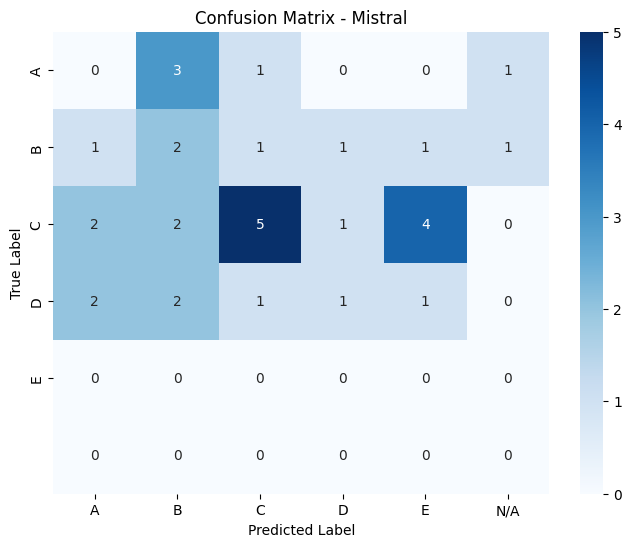

{'accuracy': 0.24242424242424243,
 'f1': 0.1809090909090909,
 'fail_ratio': 0.06060606060606061,
 'confusion_matrix': array([[0, 3, 1, 0, 0, 1],
        [1, 2, 1, 1, 1, 1],
        [2, 2, 5, 1, 4, 0],
        [2, 2, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]])}

In [ ]:
y_true = hard_data['correct_answer'].tolist()
mistral_metrics = compute_metrics(y_true, predictions, 'Mistral')
mistral_metrics

## Few-Shot Inference

In [36]:
prompt_template_few_shot = [
    {
        'role': 'system',
        'content': 'Sei un esperto di finanza e macroeconomia. Rispondi solo con la lettera della risposta corretta.'
    },
    {
        'role': 'user',
        'content': """l tuo compito è di rispondere alla seguente
         domanda a scelta multipla basandoti esclusivamente sulle tue
         conoscenze o sul contesto fornito.

         Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

         Questa è la lista di esempi dalla quale puoi prendere spunto:

{examples}

Ora rispondi alla seguente domanda:
Domanda: {question}

A) {choiceA}
B) {choiceB}
C) {choiceC}
D) {choiceD}
E) {choiceE}

Risposta:"""
    }
]



#### Fixed few-shot

In [37]:
def build_few_shot_demonstrations(
    demonstrations: pd.DataFrame,
    total_examples: int = 2,
    shuffle: bool = True,
    random_state: int = None
) -> str:
    """
    Seleziona un numero totale di esempi casuali dal dataframe.
    """
    selected_demos = demonstrations.sample(n=total_examples, random_state=random_state)

    demo_string = ""
    for _, row in selected_demos.iterrows():
        demo_string += f"Domanda: {row['question']}\n"
        demo_string += f"A) {row['choiceA']}\nB) {row['choiceB']}\nC) {row['choiceC']}\nD) {row['choiceD']}\nE) {row['choiceE']}\n"
        demo_string += f"Risposta: {row['correct_answer']}\n\n---\n\n"

    return demo_string

In [38]:
# 1. Prepariamo gli esempi fissi all'esterno del ciclo
fixed_demos_string = build_few_shot_demonstrations(
    demonstrations=sample_data,
    total_examples=2,
    random_state=42 # Seed fisso per replicabilità
)

# 2. Modifichiamo la chiamata a prepare_prompts_few_shot (logica semplificata)
def prepare_prompts_fixed(target_df, prompt_template, tokenizer, fixed_demos):
    formatted_prompts = []
    user_content_base = prompt_template[1]['content']

    for _, row in target_df.iterrows():
        # Sostituiamo {examples} con la stringa fissa
        user_content = user_content_base.replace('{examples}', fixed_demos)
        user_content = user_content.format(
            question=row['question'],
            choiceA=row['choiceA'], choiceB=row['choiceB'],
            choiceC=row['choiceC'], choiceD=row['choiceD'], choiceE=row['choiceE']
        )

        current_prompt = [prompt_template[0], {'role': 'user', 'content': user_content}]
        formatted_string = tokenizer.apply_chat_template(current_prompt, tokenize=False, add_generation_prompt=True)
        formatted_prompts.append(formatted_string)

    return formatted_prompts



In [39]:
prompts_fixed = prepare_prompts_fixed(validation_data, prompt_template_few_shot, tokenizer, fixed_demos_string)

In [ ]:
print(prompts_fixed[0])

<s>[INST] Sei un esperto di finanza e macroeconomia. Rispondi solo con la lettera della risposta corretta.

l tuo compito è di rispondere alla seguente
         domanda a scelta multipla basandoti esclusivamente sulle tue
         conoscenze o sul contesto fornito.

         Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

         Questa è la lista di esempi dalla quale puoi prendere spunto:

Domanda: Cosa descrive meglio i costi di agenzia nel contesto dell'impresa?
A) Costi sostenuti dai mandanti per garantire che gli agenti agiscano nel loro interesse.
B) Costi associati esclusivamente all'emissione di titoli di capitale e di debito.
C) Costi derivanti dalla conformità normativa e dalle spese legali.
D) Costi indipendenti dalla struttura proprietaria dell'impresa.
E) Nessuna delle precedenti
Risposta: A

---

Domanda: 1. Il concetto di vantaggio comparato si applica solo alle industrie concentrate con elevate barriere all'ingresso.
2. Gli 

In [ ]:
print(prompts_fixed[1])

<s>[INST] Sei un esperto di finanza e macroeconomia. Rispondi solo con la lettera della risposta corretta.

l tuo compito è di rispondere alla seguente
         domanda a scelta multipla basandoti esclusivamente sulle tue
         conoscenze o sul contesto fornito.

         Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

         Questa è la lista di esempi dalla quale puoi prendere spunto:

Domanda: Cosa descrive meglio i costi di agenzia nel contesto dell'impresa?
A) Costi sostenuti dai mandanti per garantire che gli agenti agiscano nel loro interesse.
B) Costi associati esclusivamente all'emissione di titoli di capitale e di debito.
C) Costi derivanti dalla conformità normativa e dalle spese legali.
D) Costi indipendenti dalla struttura proprietaria dell'impresa.
E) Nessuna delle precedenti
Risposta: A

---

Domanda: 1. Il concetto di vantaggio comparato si applica solo alle industrie concentrate con elevate barriere all'ingresso.
2. Gli 

In [40]:
raw_responses = generate_responses(model, prompts_fixed, tokenizer, batch_size=4, max_tokens=20)

In [41]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)


Output of generate_responses ('Raw' Model Responses)

['D) 3', 'A) 1, 4', 'E) Nessuna delle precedenti', 'C) C. Le aziende vendono prodotti identici e competano fissando', 'D) 1, 2, 4', '898 |\n| **Totale ricavi** | 53.47', 'A) 1, 4', 'C) Maggiore esposizione ai rischi di coda che potrebbero', 'B) Il grado di allineamento dei movimenti congiunti del capitale', 'D) 11,46%', 'B) Tutte le risposte sono corrette.', 'A) 1, 2, 4, 5', 'A) Il rapporto tra rischio e rendimento atteso non è lineare e var', 'A) 2', 'C) Rischio di carenza di capitale (CSR)', 'C) Le loro prestazioni sono generalmente inferiori a causa degli elevati costi di trans', 'A) Un surplus di beni si verifica quando i produttori offrono più', 'ive** | | 1.794.646| 1.62', '2.562 | -21 | 7.913 | 17', 'C) 391.687.603', 'D', 'E) Nessuna delle precedenti', 'B) B. Potenziale perdita di concorrenza, con conseguente cre', 'A) 1, 2, 3\n\nIl modello del fattore q', 'A) 784.177', 'B) Altre debiti a breve termine', 'C) 2, 3, 4', '.000.

In [42]:
predictions = [process_response(r) for r in raw_responses]

In [43]:
print("\nOutput of process_response (Parsed Answers)\n")
print(predictions)


Output of process_response (Parsed Answers)

['D', 'A', 'E', 'C', 'D', 'N/A', 'A', 'C', 'B', 'D', 'B', 'A', 'A', 'A', 'C', 'C', 'A', 'N/A', 'N/A', 'C', 'D', 'E', 'B', 'A', 'A', 'B', 'C', 'N/A', 'A', 'C', 'E', 'C', 'N/A', 'N/A', 'C', 'C', 'E', 'N/A', 'A', 'E', 'C', 'E', 'C', 'E', 'A', 'B', 'C', 'D', 'B', 'B', 'D', 'N/A', 'A', 'B', 'A', 'A', 'D', 'E', 'N/A', 'N/A', 'E', 'A', 'N/A', 'A', 'D', 'C', 'C', 'C', 'N/A', 'B', 'D', 'D', 'N/A', 'B', 'E', 'D', 'D', 'N/A', 'N/A', 'A', 'E', 'E', 'B', 'C', 'E', 'C', 'D', 'C', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'N/A', 'B', 'C', 'N/A', 'N/A', 'D', 'A', 'D', 'N/A', 'A', 'E', 'C', 'D', 'E', 'N/A', 'A', 'C', 'C', 'A', 'E', 'A', 'C', 'A', 'C', 'A', 'E', 'A', 'E', 'N/A', 'N/A', 'A', 'A', 'A', 'A', 'E', 'A', 'N/A', 'E', 'B', 'N/A', 'N/A', 'D', 'B', 'C', 'N/A', 'C', 'A', 'A', 'E', 'E', 'B', 'C', 'B', 'A', 'D', 'C', 'N/A', 'C', 'N/A', 'D', 'B', 'A', 'N/A', 'C', 'A', 'N/A', 'E', 'E', 'C', 'B', 'A', 'C', 'N/A', 'A', 'A', 'D', 'C', 'A', 'C', 'N/A', 'B', 'A',

In [44]:
save_results(validation_data, predictions, raw_responses, technique_name="few_shot_fixed", model_name="mistral")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project//results/mistral_few_shot_fixed.json



📊 METRICHE PER: Mistral
Accuracy:   33.60%
F1-Score:   0.3070 (Macro)
Fail Ratio: 15.00% (75/500 risposte non valide)
------------------------------


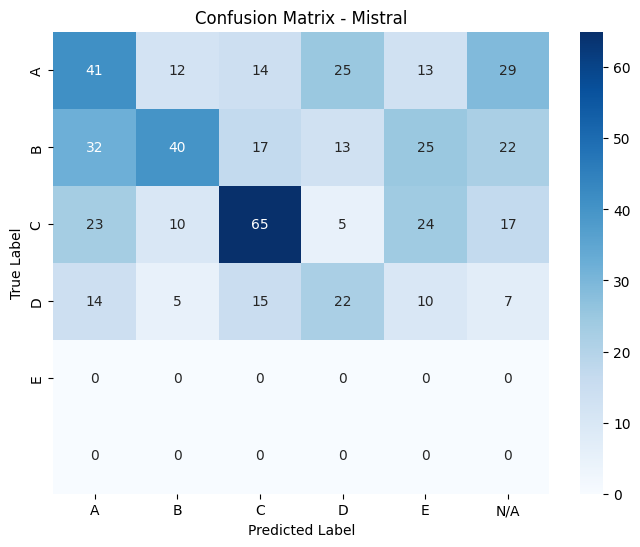

{'accuracy': 0.336,
 'f1': 0.30701608908392686,
 'fail_ratio': 0.15,
 'confusion_matrix': array([[41, 12, 14, 25, 13, 29],
        [32, 40, 17, 13, 25, 22],
        [23, 10, 65,  5, 24, 17],
        [14,  5, 15, 22, 10,  7],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])}

In [45]:
mistral_metrics = compute_metrics(y_true_val, predictions, 'Mistral')
mistral_metrics

In [46]:
# 1. Inizializza un nuovo run su W&B
run = wandb.init(
    entity="BigDataProject",
    project="BigData_project",
    name="mistral-few-shot-2-examples-eval",
    config={
        "model": "mistralai/Mistral-7B-Instruct-v0.3",
        "technique": "few-shot",
        "k_shots": 2,
        "dataset": "validation_set_IT",
        "quantization": "4bit"
    }
)

# 2. Crea una Tabella W&B per l'ispezione dei risultati
# Definiamo le colonne della tabella
columns = [
    "id", "category", "difficulty", "question",
    "correct_answer", "prediction", "is_correct", "raw_response"
]
test_table = wandb.Table(columns=columns)

# Supponiamo che 'validation_data' sia il tuo DataFrame e 'predictions' e 'raw_responses'
# siano le liste generate dai tuoi cicli di inferenza
for i, row in validation_data.iterrows():
    pred = predictions[i]
    target = row['correct_answer']

    test_table.add_data(
        row['custom_id'],
        row['category'],
        row['difficulty_level'],
        row['question'],
        target,
        pred,
        (pred == target), # True se corretta
        raw_responses[i]
    )

# 3. Logga la tabella e le metriche finali
wandb.log({
    "evaluation_table": test_table,
    "accuracy": mistral_metrics['accuracy'],
    "f1_macro": mistral_metrics['f1'],
    "fail_ratio": mistral_metrics['fail_ratio']
})

# 4. Chiudi il run
wandb.finish()

accuracy,▁
f1_macro,▁
fail_ratio,▁
accuracy,0.336
f1_macro,0.30702
fail_ratio,0.15


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_benchmark_report(results_list, names):
    """
    results_list: lista di oggetti ritornati da evaluation.evaluate()
    names: nomi delle tecniche ['Zero-Shot', 'CoT', 'Few-Shot']
    """
    data = []
    for res, name in zip(results_list, names):
        # Estraiamo le metriche aggregate da Weave
        acc = res['correct']['mean'] * 100
        # Se hai loggato il tempo (latence) lo aggiungi qui
        data.append({
            'Tecnica': name,
            'Accuracy (%)': acc,
            'Error Rate (%)': 100 - acc
        })

    summary_df = pd.DataFrame(data)

    # --- CREAZIONE TABELLA ---
    print("\n📊 TABELLA COMPARATIVA METRICHE")
    display(summary_df.sort_values('Accuracy (%)', ascending=False))

    # --- CREAZIONE PLOT ---
    plt.figure(figsize=(10, 6))
    bars = plt.bar(summary_df['Tecnica'], summary_df['Accuracy (%)'], color=['#3498db', '#e74c3c', '#2ecc71'])
    plt.axhline(y=summary_df['Accuracy (%)'].mean(), color='gray', linestyle='--', label='Media')
    plt.ylabel('Accuracy (%)')
    plt.title('Confronto Performance per Tecnica di Prompting')
    plt.ylim(0, 100)

    # Aggiungi i valori sopra le barre
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center')

    plt.legend()
    plt.show()

In [ ]:
import asyncio

async def run_benchmark():
    # 1. Preparazione del Dataset per Weave
    eval_dataset = df_benchmark.to_dict('records')

    # 2. Definizione della Valutazione (Scorer)
    evaluation = weave.Evaluation(
        name="Finance_Multi_Prompting_Test",
        dataset=eval_dataset,
        scorers=[exact_match_scorer], # La tua funzione di confronto
    )

    # 3. Richiamo dei modelli con diversi prompt
    print("--- 🟢 Avvio Zero-Shot ---")
    model_zs = UniversalFinanceModel(
        model_obj=model, tokenizer=tokenizer,
        technique="zero_shot", prompt_template=prompt_template_base
    )
    res_zs = await evaluation.evaluate(model_zs)

    print("--- 🟡 Avvio Few-Shot ---")
    model_fs = UniversalFinanceModel(
        model_obj=model, tokenizer=tokenizer,
        technique="few_shot", prompt_template=prompt_template_few_shot,
        demonstrations_df=df_examples # Passiamo il df degli esempi
    )
    res_fs = await evaluation.evaluate(model_fs)

    print("--- 🔴 Avvio Chain-of-Thought ---")
    model_cot = UniversalFinanceModel(
        model_obj=model, tokenizer=tokenizer,
        technique="cot", prompt_template=prompt_template_cot
    )
    res_cot = await evaluation.evaluate(model_cot)

    # 4. Generazione Report Finale
    all_results = [res_zs, res_fs, res_cot]
    all_names = ["Zero-Shot", "Few-Shot", "CoT"]

    # Richiamiamo la funzione di plot che abbiamo creato prima
    generate_benchmark_report(all_results, all_names)

# In Colab/Notebook esegui così:
await run_benchmark()

#### Random few-shot

In [47]:
def prepare_prompts_random_reproducible(
    target_df: pd.DataFrame,
    prompt_template: list,
    tokenizer: any,
    demonstrations_df: pd.DataFrame,
    total_examples: int = 2
) -> list:

    formatted_prompts = []
    user_content_base = prompt_template[1]['content']

    for _, row in target_df.iterrows():
        # Creiamo un seed univoco per questa specifica domanda
        # Usiamo SHA256 del testo della domanda per ottenere un numero intero
        question_hash = hashlib.sha256(row['question'].encode('utf-8')).hexdigest()
        seed = int(question_hash, 16) % (2**32) # Limitiamo il range per compatibilità con pandas

        # Generiamo i 2 esempi usando quel seed specifico
        dynamic_demos = build_few_shot_demonstrations(
            demonstrations=demonstrations_df,
            total_examples=total_examples,
            random_state=seed
        )

        # Sostituzione nel template
        user_content = user_content_base.replace('{examples}', dynamic_demos)
        user_content = user_content.format(
            question=row['question'],
            choiceA=row['choiceA'], choiceB=row['choiceB'],
            choiceC=row['choiceC'], choiceD=row['choiceD'], choiceE=row['choiceE']
        )

        current_prompt = [
            prompt_template[0],
            {'role': 'user', 'content': user_content}
        ]

        # Formattazione per il modello
        formatted_string = tokenizer.apply_chat_template(
            current_prompt,
            tokenize=False,
            add_generation_prompt=True
        )
        formatted_prompts.append(formatted_string)

    return formatted_prompts


In [48]:
# Esecuzione
prompts_random = prepare_prompts_random_reproducible(
    validation_data,
    prompt_template_few_shot,
    tokenizer,
    sample_data,
    total_examples=2
)

In [49]:
print(prompts_random[0])

<s>[INST] Sei un esperto di finanza e macroeconomia. Rispondi solo con la lettera della risposta corretta.

l tuo compito è di rispondere alla seguente
         domanda a scelta multipla basandoti esclusivamente sulle tue
         conoscenze o sul contesto fornito.

         Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

         Questa è la lista di esempi dalla quale puoi prendere spunto:

Domanda: 1. Quando si considerano i casi di attività dannose, è essenziale bilanciare la riduzione totale del valore della produzione con i guadagni derivanti dalla prevenzione degli effetti dannosi, al fine di massimizzare il benessere sociale.
2. Le normative o le imposte governative volte a mitigare gli effetti dannosi sono sempre in grado di migliorare l'efficienza economica complessiva e il benessere sociale.
3. Secondo l'analisi tradizionale, rendere una fabbrica responsabile dei danni che provoca porterebbe sempre a un'allocazione socialmente otti

In [50]:
print(prompts_random[1])

<s>[INST] Sei un esperto di finanza e macroeconomia. Rispondi solo con la lettera della risposta corretta.

l tuo compito è di rispondere alla seguente
         domanda a scelta multipla basandoti esclusivamente sulle tue
         conoscenze o sul contesto fornito.

         Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

         Questa è la lista di esempi dalla quale puoi prendere spunto:

Domanda: 1. L'azienda tradizionale multidomestica ha un alto livello di aggregazione globale e un basso livello di adattamento locale.
2. Il modello organizzativo internazionale è caratterizzato da aziende che hanno una forte dipendenza dalle vendite nazionali e che esportano prodotti in modo opportunistico.
3. Il modello transnazionale mira a ridurre al minimo i processi di gestione per diventare più efficiente nel processo decisionale.
4. Il modello organizzativo multidomestico consente un significativo trasferimento di conoscenze dalla sede centrale d

In [51]:
raw_responses = generate_responses(model, prompts_random, tokenizer, batch_size=4, max_tokens=20)

In [52]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)


Output of generate_responses ('Raw' Model Responses)

['B) 1, 2', 'D) 1, 2, 3', 'E) Nessuna delle precedenti', 'C) C. Le aziende vendono prodotti identici e competano fissando', '0 & 28 | 187 | 221 |\n| Altri', '0 & 28 | 187 | 221 |\n| Altri', 'B) Tutte le risposte sono corrette.', 'C) Maggiore esposizione ai rischi di coda che potrebbero', 'B) Il grado di allineamento dei movimenti congiunti del capitale', 'C) 7,82%', 'B) Tutte le risposte sono corrette.', 'li investimenti in azioni sono considerati un tipo di investimento di tipo passivo.', 'A) Il rapporto tra rischio e rendimento atteso non è lineare e var', 'Il boom economico si riferisce alla crescita economica negli anni dal 1', 'C) Rischio di carenza di capitale (CSR)', 'C) Le loro prestazioni sono generalmente inferiori a causa degli elevati costi di trans', 'ASSIVITÀ CORRENTI** | | **420.224', '551.961 |\n| **Totale debiti** |', '047** | **537.032** |\n| **Tot', 'C) 391.687.603', '11 | 10.148 | 10.148 |', 'A) 1, 2, 3', 'B) B.

In [53]:
predictions = [process_response(r) for r in raw_responses]

In [54]:
print("\nOutput of process_response (Parsed Answers)\n")
print(predictions)


Output of process_response (Parsed Answers)

['B', 'D', 'E', 'C', 'N/A', 'N/A', 'B', 'C', 'B', 'C', 'B', 'N/A', 'A', 'N/A', 'C', 'C', 'A', 'N/A', 'N/A', 'C', 'N/A', 'A', 'B', 'C', 'A', 'N/A', 'E', 'A', 'C', 'N/A', 'D', 'N/A', 'E', 'N/A', 'E', 'C', 'E', 'N/A', 'C', 'D', 'C', 'E', 'N/A', 'E', 'E', 'B', 'D', 'D', 'B', 'B', 'D', 'N/A', 'A', 'B', 'C', 'A', 'D', 'N/A', 'N/A', 'N/A', 'N/A', 'B', 'N/A', 'N/A', 'D', 'C', 'C', 'C', 'N/A', 'B', 'D', 'D', 'N/A', 'A', 'A', 'D', 'N/A', 'A', 'N/A', 'A', 'E', 'N/A', 'B', 'C', 'E', 'C', 'N/A', 'C', 'N/A', 'B', 'E', 'C', 'C', 'N/A', 'N/A', 'N/A', 'N/A', 'B', 'C', 'N/A', 'E', 'D', 'N/A', 'N/A', 'N/A', 'N/A', 'E', 'C', 'N/A', 'C', 'C', 'B', 'N/A', 'N/A', 'A', 'N/A', 'A', 'B', 'A', 'N/A', 'D', 'E', 'C', 'C', 'N/A', 'N/A', 'N/A', 'E', 'D', 'N/A', 'E', 'N/A', 'N/A', 'E', 'B', 'N/A', 'N/A', 'C', 'B', 'C', 'N/A', 'C', 'B', 'N/A', 'N/A', 'C', 'B', 'B', 'N/A', 'A', 'D', 'N/A', 'N/A', 'B', 'N/A', 'D', 'B', 'E', 'N/A', 'C', 'N/A', 'A', 'N/A', 'E', 'C', 'N/A', 'D'

In [55]:
# Calcola accuratezza semplice
accuracy = (predictions == validation_data['correct_answer']).mean()
print(f"Accuracy Few-Shot: {accuracy:.2%}")

Accuracy Few-Shot: 24.60%


In [ ]:
save_results(validation_data, predictions, raw_responses, technique_name="few_shot_random", model_name="mistral")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/mistral_few_shot_random.json



📊 METRICHE PER: Mistral
Accuracy:   24.60%
F1-Score:   0.2455 (Macro)
Fail Ratio: 31.00% (155/500 risposte non valide)
------------------------------


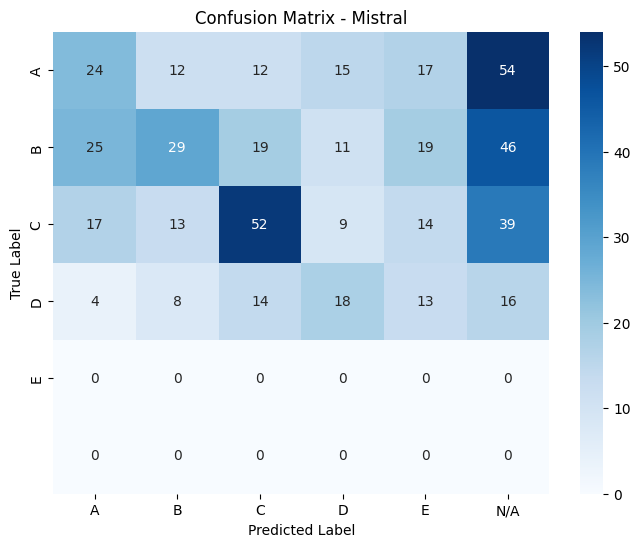

{'accuracy': 0.246,
 'f1': 0.2454850379317132,
 'fail_ratio': 0.31,
 'confusion_matrix': array([[24, 12, 12, 15, 17, 54],
        [25, 29, 19, 11, 19, 46],
        [17, 13, 52,  9, 14, 39],
        [ 4,  8, 14, 18, 13, 16],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])}

In [56]:
mistral_metrics = compute_metrics(y_true_val, predictions, 'Mistral')
mistral_metrics

In [57]:
# 1. Inizializza un nuovo run su W&B
run = wandb.init(
    entity="BigDataProject",
    project="BigData_project",
    name="mistral-few-shot-2-Random-examples-eval",
    config={
        "model": "mistralai/Mistral-7B-Instruct-v0.3",
        "technique": "few-shot-random",
        "k_shots": 2,
        "dataset": "validation_set_IT",
        "quantization": "4bit"
    }
)

# 2. Crea una Tabella W&B per l'ispezione dei risultati
# Definiamo le colonne della tabella
columns = [
    "id", "category", "difficulty", "question",
    "correct_answer", "prediction", "is_correct", "raw_response"
]
test_table = wandb.Table(columns=columns)

# Supponiamo che 'validation_data' sia il tuo DataFrame e 'predictions' e 'raw_responses'
# siano le liste generate dai tuoi cicli di inferenza
for i, row in validation_data.iterrows():
    pred = predictions[i]
    target = row['correct_answer']

    test_table.add_data(
        row['custom_id'],
        row['category'],
        row['difficulty_level'],
        row['question'],
        target,
        pred,
        (pred == target), # True se corretta
        raw_responses[i]
    )

# 3. Logga la tabella e le metriche finali
wandb.log({
    "evaluation_table": test_table,
    "accuracy": mistral_metrics['accuracy'],
    "f1_macro": mistral_metrics['f1'],
    "fail_ratio": mistral_metrics['fail_ratio']
})

# 4. Chiudi il run
wandb.finish()

accuracy,▁
f1_macro,▁
fail_ratio,▁
accuracy,0.246
f1_macro,0.24549
fail_ratio,0.31


## Instruction-tuned prompting

In [ ]:
PROMPTS = {
            "free": [
                      {'role': 'system', 'content': 'Rispondi alla domanda a scelta multipla. Rispondi solo con la lettera corretta.'},
                      {'role': 'user', 'content': """Domanda a scelta multipla: {question}

                      A) {choiceA}
                      B) {choiceB}
                      C) {choiceC}
                      D) {choiceD}
                      E) {choiceE}

                      Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

                      Risposta:"""}
                  ],

            "verify": [
                        {
                            'role': 'system',
                            'content': 'Sei un esperto di finanza e macroeconomia. Controlla attentamente le opzioni due volte prima di rispondere. Rispondi solo con la lettera.'
                        },
                        {
                            'role': 'user',
                            'content': """Leggi la domanda a scelta multipla e verifica due volte quale opzione è corretta.
                            Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

                        Domanda: {question}

                        A) {choiceA}
                        B) {choiceB}
                        C) {choiceC}
                        D) {choiceD}
                        E) {choiceE}

                        Risposta:"""
                        }
                      ],

            "confidence": [
                            {
                                'role': 'system',
                                'content': 'Sei un esperto di finanza e macroeconomia. Analizza i problemi in modo analitico e rigoroso e rispondi con la lettera corretta.'
                            },
                            {
                                'role': 'user',
                                'content': """Il tuo compito è di rispondere alla seguente domanda a scelta multipla basandoti esclusivamente sulle tue conoscenze o sul contesto fornito.

                                Domanda: {question}

                                A) {choiceA}
                                B) {choiceB}
                                C) {choiceC}
                                D) {choiceD}
                                E) {choiceE}

                                Istruzioni:
                                1. Valuta attentamente ogni opzione.
                                2. Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.
                                3. Indica quanto sei sicuro della tua risposta su una scala da 1 a 5 (5 = molto sicuro). Fornire solo il numero senza alcuna spiegazione.

                                CRITICAL: Devi rispondere **solo** nel seguente formato. Non aggiungere preamboli o testo extra:

                                Risposta: [A or B or C or D or E]
                                Confidence: [1-5]
                                """
                                    }
                                ],

            "contrastive":  [
                            {
                                'role': 'system',
                                'content': 'Sei un esperto di finanza e macroeconomia. Analizza i problemi in modo analitico e rigoroso.'
                            },
                            {
                                'role': 'user',
                                'content': """Il tuo compito è di rispondere alla seguente domanda a scelta multipla basandoti esclusivamente sulle tue conoscenze o sul contesto fornito.

                              Domanda: {question}

                              A) {choiceA}
                              B) {choiceB}
                              C) {choiceC}
                              D) {choiceD}
                              E) {choiceE}

                              Istruzioni:
                              1. Analizza tutte le opzioni.
                              2. Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.
                              3. Fornisci una breve spiegazione del perché le altre opzioni sono errate.

                              CRITICAL: Devi rispondere **solo** nel seguente formato. Non aggiungere preamboli o testo extra:

                              Risposta: [A or B or C or D or E]
                              Contrast_analysis: [breve spiegazione perché le altre opzioni sono errate]
                              """
                                  }
                              ],

            "high_structure": [
                                    {'role': 'system', 'content': 'Sei un docente esperto di economia aziendale. Analizza ogni opzione e valuta se è vera o falsa, poi fornisci solo la lettera corretta.'},
                                    {'role': 'user', 'content': """ Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

                                    Domanda a scelta multipla: {question}

                                Opzioni:
                                A) {choiceA}
                                B) {choiceB}
                                C) {choiceC}
                                D) {choiceD}
                                E) {choiceE}


                                Risposta:"""}
                              ]

}



In [ ]:

def _empty_output(prompt_type):
    if prompt_type == "confidence":
        return {"RISPOSTA": "N/A", "CONFIDENCE": "N/A"}
    if prompt_type == "contrastive":
        return {"RISPOSTA": "N/A", "CONTRAST_ANALYSIS": "N/A"}
    return "N/A"


VALID_LETTERS = {"A", "B", "C", "D", "E"}


def process_response_prompting_tuning(response, prompt_type="high_structure", strict=False):
    """
    Estrae e valida i campi principali dalle risposte generate.

    Inputs:
        response (str): testo generato dal modello
        prompt_type (str): cot | confidence | contrastive | high_structure | verify
        strict (bool): se True accetta SOLO il formato esplicito richiesto

    Outputs:
        - cot / verify / high_structure -> str (A–E o "N/A")
        - confidence -> dict {RISPOSTA, CONFIDENCE}
        - contrastive -> dict {RISPOSTA, CONTRAST_ANALYSIS}
    """

    if not response or not response.strip():
        return _empty_output(prompt_type)

    response = response.strip()

    match_explicit = re.search(
        r"Risposta\s*:\s*([A-E])\b", response, re.IGNORECASE
    )

    answer_letter = None
    if match_explicit:
        answer_letter = match_explicit.group(1).upper()


    if not answer_letter and not strict:
        # Pattern tipo: "la risposta corretta è C", "quindi D è giusta"
        fallback_matches = re.findall(
            r"\b([A-E])\b(?=.{0,30}(corretta|giusta|vera|risposta))",
            response.lower()
        )
        if fallback_matches:
            answer_letter = fallback_matches[-1][0].upper()

    # Ultimo fallback: ultima lettera A–E nel testo
    if not answer_letter and not strict:
        all_letters = re.findall(r"\b([A-E])\b", response.upper())
        if all_letters:
            answer_letter = all_letters[-1]


    if answer_letter not in VALID_LETTERS:
        answer_letter = "N/A"


    if prompt_type == "confidence":
        match_conf = re.search(r"Confidence\s*:\s*([1-5])\b", response)
        confidence = match_conf.group(1) if match_conf else "N/A"

        return {
            "RISPOSTA": answer_letter,
            "CONFIDENCE": confidence
        }


    if prompt_type == "contrastive":
        match_contrast = re.search(
            r"Contrast_analysis\s*:\s*(.*)",
            response,
            re.IGNORECASE | re.DOTALL
        )
        contrast = match_contrast.group(1).strip() if match_contrast else "N/A"

        return {
            "RISPOSTA": answer_letter,
            "CONTRAST_ANALYSIS": contrast
        }

    return answer_letter




In [ ]:
#da rivedere
def prompting_tuning(model, validation data, tokenizer, ):

all_results = {}

for prompt_name, prompt_template in PROMPTS.items():
    print(f"Running prompt: {prompt_name}")

    prompts = prepare_prompts(validation_data, prompt_template, tokenizer)

    raw_responses = generate_responses(
        model,
        prompts,
        tokenizer,
        batch_size=4
    )

    # 3. Parsing
    predictions = [
        process_response_prompting_tuning(r, prompt_type=prompt_name)
        for r in raw_responses
    ]

    all_results[prompt_name] = predictions

return all_results

## Chain-of-thought (CoT) prompting

In [59]:
prompt_template_cot = [
    {
        'role': 'system',
        'content': 'Sei un esperto di finanza e macroeconomia. Analizza i problemi in modo analitico e rigoroso.'
    },
    {
        'role': 'user',
        'content': """Il tuo compito è di rispondere alla seguente
         domanda a scelta multipla basandoti esclusivamente sulle tue
         conoscenze o sul contesto fornito.

        Domanda: {question}

        A) {choiceA}
        B) {choiceB}
        C) {choiceC}
        D) {choiceD}
        E) {choiceE}

        Istruzioni:
        1. Identifica l'argomento principale (es. contabilità, politica fiscale, macroeconomia).
        2. Valuta brevemente ogni opzione (A, B, C, D, E).
        3. Rispondi fornendo solo la lettera (A, B, C, D, o E) corrispondente alla risposta corretta.

        IMPORTANT: Even if multiple categories apply, select ONLY the ONE most fitting category.

        CRITICAL: You must respond with ONLY the following format. Do not add any preamble, explanation, or extra text:

        REASONING: [Your step-by-step analysis here]
        RISPOSTA: [A or B or C or D or E]
        """
    }
]

In [60]:
def generate_responses_cot(model, prompt_examples, tokenizer, batch_size=4):
    generated_texts = []
    model.eval()

    for i in range(0, len(prompt_examples), batch_size):
        batch = [p for p in prompt_examples[i:i + batch_size] if p is not None]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=450,  # Aumentato per permettere il ragionamento
                do_sample=False,     # Manteniamo deterministico
                temperature=0,
                pad_token_id=tokenizer.pad_token_id
            )

        for j, output_sequence in enumerate(outputs):
            start_index = inputs['input_ids'][j].shape[0]
            decoded_text = tokenizer.decode(output_sequence[start_index:], skip_special_tokens=True).strip()
            generated_texts.append(decoded_text)

    return generated_texts

In [61]:
prompts = prepare_prompts(validation_data, prompt_template_cot, tokenizer)

In [ ]:
raw_responses = generate_responses_cot(model, prompts, tokenizer)

In [ ]:
raw_responses = generate_responses(model, prompts, tokenizer, max_tokens=450)

In [ ]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)

In [ ]:
def process_response_cot(response):
    if not response: return "N/A"

    # 1. Cerca il trigger specifico richiesto
    match_finale = re.search(r"RISPOSTA:\s*([A-E])", response, re.IGNORECASE)
    if match_finale:
        return match_finale.group(1).upper()

    # 2. Se non c'è il trigger, cerca l'ultima lettera associata a una scelta corretta/vera
    # Spesso il modello scrive: "Quindi la C è corretta"
    match_inferenza = re.findall(r"([A-E])\b(?=.{0,20}(?:corretta|vera|giusta|risposta))", response.lower())
    if match_inferenza:
        return match_inferenza[-1].upper()

    # 3. Fallback: l'ultima lettera A-E trovata nel testo (spesso la conclusione)
    # Escludiamo le lettere che sembrano far parte di tabelle o elenchi iniziali
    clean_text = re.sub(r'^[1-5]\.\s', '', response) # Rimuove numerazioni iniziali
    all_letters = re.findall(r"\b([A-E])\b", clean_text.upper())
    if all_letters:
        return all_letters[-1]

    return "N/A"

In [ ]:
predictions = [process_response_cot(r) for r in raw_responses]
validation_data['prediction_cot'] = predictions

In [ ]:
print("\nOutput of process_response (Parsed Answers)\n")
print(predictions)

In [ ]:
save_results(validation_data, predictions, raw_responses, technique_name="cot_shot", model_name="mistral")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/mistral_cot_shot.json


In [ ]:
# Calcola accuratezza semplice
accuracy = (validation_data['prediction_cot'] == validation_data['correct_answer']).mean()
print(f"Accuracy Zero-Shot: {accuracy:.2%}")

Accuracy Zero-Shot: 40.00%


In [ ]:
mistral_metrics = compute_metrics(y_true_val, predictions, 'Mistral')
mistral_metrics

In [ ]:
# 1. Inizializza un nuovo run su W&B
run = wandb.init(
    entity="BigDataProject",
    project="BigData_project",
    name="mistral-cot-eval",
    config={
        "model": "mistralai/Mistral-7B-Instruct-v0.3",
        "technique": "CoT",
        "dataset": "validation_set_IT",
        "quantization": "4bit"
    }
)

# 2. Crea una Tabella W&B per l'ispezione dei risultati
# Definiamo le colonne della tabella
columns = [
    "id", "category", "difficulty", "question",
    "correct_answer", "prediction", "is_correct", "raw_response"
]
test_table = wandb.Table(columns=columns)

# Supponiamo che 'validation_data' sia il tuo DataFrame e 'predictions' e 'raw_responses'
# siano le liste generate dai tuoi cicli di inferenza
for i, row in validation_data.iterrows():
    pred = predictions[i]
    target = row['correct_answer']

    test_table.add_data(
        row['custom_id'],
        row['category'],
        row['difficulty_level'],
        row['question'],
        target,
        pred,
        (pred == target), # True se corretta
        raw_responses[i]
    )

# 3. Logga la tabella e le metriche finali
wandb.log({
    "evaluation_table": test_table,
    "accuracy": mistral_metrics['accuracy'],
    "f1_macro": mistral_metrics['f1'],
    "fail_ratio": mistral_metrics['fail_ratio']
})

# 4. Chiudi il run
wandb.finish()

#### Llama

In [ ]:
prompts = prepare_prompts(validation_data, prompt_template_cot, tokenizer)

In [ ]:
raw_responses = generate_responses(model, prompts, tokenizer, max_tokens=450)

In [ ]:
print("\nOutput of generate_responses ('Raw' Model Responses)\n")
print(raw_responses)


Output of generate_responses ('Raw' Model Responses)

["REASONING: \nL'affermazione 1 è vera perché il committente massimizza i propri profitti offrendo uno stipendio sempre superiore all'utilità di riserva dell'agente, in quanto ciò aumenta la probabilità che l'agente accetti l'offerta. L'affermazione 2 è vera perché il tipo di struttura retributiva non influenza il tipo di agente che il committente attira, in quanto il committente può scegliere tra diversi tipi di struttura retributiva per attirare l'agente desiderato. L'affermazione 3 è falsa perché se un agente è neutrale al rischio, il committente non riceve una somma forfettaria dall'agente, ma piuttosto continua a pagargli uno stipendio, poiché il rischio è neutro e non influenza la scelta del committente.\n\nRISPOSTA: B", "REASONING: \n1. Il sistema bancario ombra è un tipo di sistema bancario che crea debiti insensibili alle informazioni, quindi l'affermazione 1 è vera.\n2. La creazione di un sistema bancario ombra non è stat

In [ ]:
predictions = [process_response_cot(r) for r in raw_responses]

In [ ]:
print("\nOutput of process_response (Parsed Answers)\n")
print(predictions)


Output of process_response (Parsed Answers)

['B', 'D', 'D', 'C', 'E', 'B', 'D', 'C', 'B', 'A', 'C', 'A', 'D', 'A', 'D', 'C', 'C', 'C', 'B', 'A', 'C', 'C', 'D', 'D', 'B', 'A', 'A', 'D', 'C', 'C', 'D', 'A', 'B', 'B', 'D', 'D', 'C', 'A', 'C', 'C', 'C', 'D', 'B', 'A', 'A', 'B', 'A', 'A', 'B', 'C', 'D', 'A', 'B', 'B', 'E', 'A', 'C', 'C', 'A', 'C', 'C', 'C', 'B', 'A', 'A', 'C', 'C', 'A', 'B', 'B', 'C', 'B', 'C', 'B', 'E', 'A', 'A', 'A', 'C', 'A', 'C', 'A', 'A', 'C', 'C', 'C', 'A', 'B', 'B', 'C', 'A', 'B', 'B', 'E', 'B', 'E', 'A', 'C', 'C', 'B', 'A', 'D', 'A', 'B', 'D', 'B', 'A', 'C', 'D', 'A', 'B', 'B', 'C', 'A', 'D', 'B', 'A', 'C', 'B', 'B', 'A', 'A', 'C', 'B', 'B', 'D', 'B', 'C', 'D', 'A', 'B', 'A', 'B', 'D', 'B', 'E', 'C', 'D', 'B', 'A', 'A', 'C', 'C', 'A', 'B', 'E', 'B', 'C', 'A', 'A', 'A', 'B', 'C', 'C', 'A', 'A', 'A', 'C', 'E', 'C', 'E', 'B', 'C', 'C', 'A', 'B', 'A', 'C', 'D', 'A', 'D', 'C', 'C', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'C', 'D', 'A', 'D', 'D', 'A', 'A', 'C', 'C', 'C'

In [ ]:
save_results(validation_data, predictions, raw_responses, technique_name="cot_shot", model_name="llama")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/llama_cot_shot.json



📊 METRICHE PER: Llama
Accuracy:   49.40%
F1-Score:   0.4028 (Macro)
Fail Ratio: 0.60% (3/500 risposte non valide)
------------------------------


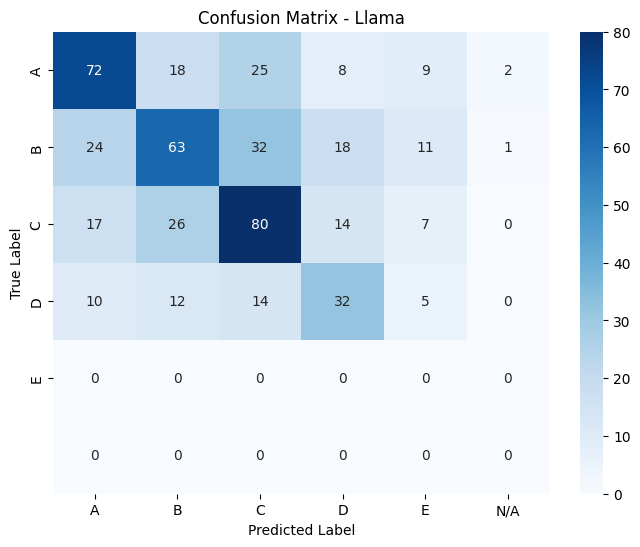

{'accuracy': 0.494,
 'f1': 0.40284254589575913,
 'fail_ratio': 0.006,
 'confusion_matrix': array([[72, 18, 25,  8,  9,  2],
        [24, 63, 32, 18, 11,  1],
        [17, 26, 80, 14,  7,  0],
        [10, 12, 14, 32,  5,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])}

In [ ]:
llama_metrics = compute_metrics(y_true_val, predictions, 'Llama')
llama_metrics

## Generate and Read Pipeline

In [ ]:
def get_logit_scores(model, tokenizer, final_prompt):
    """
    Invece di generare testo, calcola la probabilità matematica delle lettere A-E.
    """
    choices = ['A', 'B', 'C', 'D', 'E']
    inputs = tokenizer(final_prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        # Prendiamo i logits dell'ultimo token predetto
        last_token_logits = outputs.logits[0, -1, :]

    # Mappiamo i token ID delle lettere (aggiungendo uno spazio davanti spesso aiuta)
    # Molti modelli chat usano formati diversi, testiamo la lettera secca
    choice_ids = [tokenizer.encode(c, add_special_tokens=False)[-1] for c in choices]

    # Estraiamo e normalizziamo con Softmax
    target_logits = last_token_logits[choice_ids]
    probs = F.softmax(target_logits, dim=-1)

    # Risultato
    prediction = choices[torch.argmax(probs).item()]
    confidences = {choices[i]: probs[i].item() for i in range(len(choices))}

    return prediction, confidences

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
def run_generate_and_read(df, model, tokenizer):
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Pipeline G&R"):
        # --- STEP 1: GENERATE (Reasoning) ---
        # Chiediamo al modello di estrarre solo i fatti numerici o logici
        gen_prompt = f"""[INST] Sei un analista finanziario. Analizza i dati della seguente domanda e della tabella fornita.
Identifica i numeri chiave e la logica necessaria per rispondere, senza dare ancora la risposta finale.

Domanda: {row['question']}
[/INST]
Ragionamento:"""

        inputs = tokenizer(gen_prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            gen_output = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=False,
                temperature=0.0
            )

        reasoning = tokenizer.decode(gen_output[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()

        # --- STEP 2: READ & SCORE ---
        # Costruiamo il prompt finale che include il ragionamento appena fatto
        final_scorer_prompt = f"""[INST] Domanda: {row['question']}

Opzioni:
A) {row['choiceA']}
B) {row['choiceB']}
C) {row['choiceC']}
D) {row['choiceD']}
E) {row['choiceE']}

Analisi tecnica: {reasoning}

Basandoti esclusivamente sulla tua analisi sopra, indica la lettera corretta. [/INST]
La risposta corretta è la lettera:"""

        # Otteniamo la predizione via scoring (niente più troncamenti!)
        prediction, confidences = get_logit_scores(model, tokenizer, final_scorer_prompt)

        results.append({
            'custom_id': row.get('custom_id', idx),
            'category': row.get('category', 'N/A'),
            'reasoning': reasoning,
            'prediction': prediction,
            'confidence_score': confidences[prediction],
            'correct_answer': row.get('correct_answer', None),
            'full_confidences': confidences
        })

    return pd.DataFrame(results)

In [ ]:
df_results = run_generate_and_read(validation_data, model, tokenizer)

# Calcolo Accuratezza (se correct_answer è presente)
if 'correct_answer' in df_results.columns and df_results['correct_answer'].notnull().all():
    accuracy = (df_results['prediction'] == df_results['correct_answer']).mean()
    print(f"\nAccuratezza Finale Generate-and-Read: {accuracy:.2%}")

Pipeline G&R: 100%|██████████| 500/500 [2:35:40<00:00, 18.68s/it]


Accuratezza Finale Generate-and-Read: 46.40%


In [ ]:
df_results.head()

,custom_id,category,reasoning,prediction,confidence_score,correct_answer,full_confidences
0,BOOKS__1646,BOOKS,1. Il committente massimizza i propri profitti...,D,0.701660,B,"{'A': 0.004138946533203125, 'B': 0.28344726562..."
1,PAPER__3536,PAPER,1. Il sistema bancario ombra non crea debiti i...,D,0.719238,C,"{'A': 0.05462646484375, 'B': 0.016525268554687..."
2,PAPER__3297,PAPER,1. L'equilibrio competitivo richiede che ogni ...,E,0.503418,C,"{'A': 0.0168304443359375, 'B': 0.273681640625,..."
3,BOOKS__5422,BOOKS,"Per analizzare la domanda, è necessario capire...",C,1.000000,C,"{'A': 2.2649765014648438e-06, 'B': 4.768371582..."
4,PAPER__2502,PAPER,1. ∆CoVaR misura la variazione del valore a ri...,D,0.999512,D,"{'A': 4.947185516357422e-05, 'B': 0.0001465082..."


In [ ]:
# 2. Preparazione dei dati per le funzioni successive
# Estraiamo le liste necessarie per compute_metrics e save_results
y_true = df_results['correct_answer'].tolist()
y_pred = df_results['prediction'].tolist()
# Per G&R, la "raw_response" è il ragionamento prodotto nello Step 1
raw_reasons = df_results['reasoning'].tolist()


📊 METRICHE PER: Mistral-7B_Generate_and_Read
Accuracy:   46.40%
F1-Score:   0.3632 (Macro)
Fail Ratio: 0.00% (0/500 risposte non valide)
------------------------------


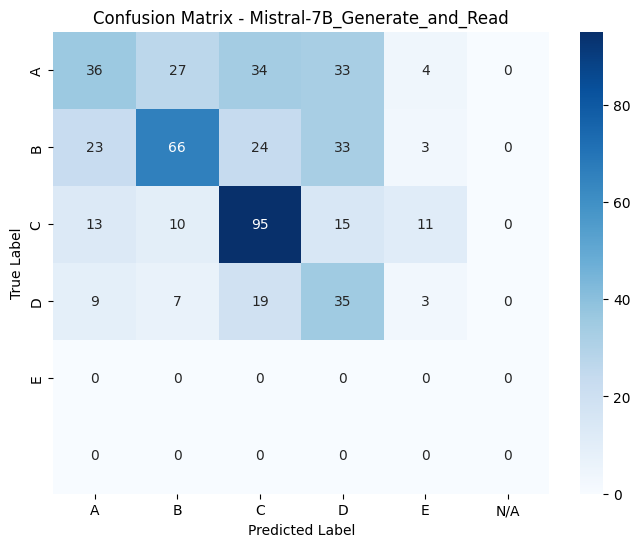

In [ ]:
# Calcolo metriche
metrics = compute_metrics(
    y_true=y_true,
    y_pred=y_pred,
    label_name="Mistral-7B_Generate_and_Read"
)

In [ ]:
columns = ['custom_id',	'category', 'reasoning',	'prediction',	'confidence_score',	'correct_answer',	'full_confidences']

file_path = f"{PATH}/results/mistral_G&R.json"
df_results[columns].to_json(file_path, orient='records', indent=4, force_ascii=False)
print(f"Risultati salvati in: {file_path}")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/mistral_G&R.json


In [ ]:
import random
import numpy as np
from tqdm import tqdm

def shuffle_options_in_df(df, seed=42):
    """
    Rimescola le opzioni A, B, C, D, E per ogni riga e aggiorna correct_answer.
    """
    random.seed(seed)
    shuffled_rows = []

    for _, row in df.iterrows():
        new_row = row.copy()

        # 1. Mappa originale delle opzioni
        labels = ['A', 'B', 'C', 'D', 'E']
        original_choices = {l: row[f'choice{l}'] for l in labels}
        correct_text = original_choices[row['correct_answer']]

        # 2. Rimescolamento dei testi
        text_list = list(original_choices.values())
        random.shuffle(text_list)

        # 3. Riassegnazione e ricerca della nuova risposta corretta
        for i, label in enumerate(labels):
            new_row[f'choice{label}'] = text_list[i]
            if text_list[i] == correct_text:
                new_row['correct_answer'] = label

        shuffled_rows.append(new_row)

    return pd.DataFrame(shuffled_rows)


In [ ]:
# --- ESECUZIONE DEL TEST DI ROBUSTEZZA ---

# 1. Creiamo il dataset "perturbato"
print("🔄 Generazione del dataset rimescolato...")
df_val_shuffled = shuffle_options_in_df(validation_data)

🔄 Generazione del dataset rimescolato...


In [ ]:
# 2. Lanciamo la pipeline Generate-and-Read sul dataset rimescolato
# Usiamo la funzione run_generate_and_read definita nello step precedente
print("🚀 Esecuzione pipeline G&R su opzioni rimescolate...")
df_results_shuffled = run_generate_and_read(df_val_shuffled, model, tokenizer)

🚀 Esecuzione pipeline G&R su opzioni rimescolate...


Pipeline G&R: 100%|██████████| 500/500 [2:38:06<00:00, 18.97s/it]


In [ ]:
# 3. Analisi comparativa
original_acc = 0.4640
shuffled_acc = (df_results_shuffled['prediction'] == df_results_shuffled['correct_answer']).mean()

In [ ]:
print("\n" + "="*30)
print("📊 ANALISI DI ROBUSTEZZA")
print(f"Accuratezza Originale: {original_acc:.2%}")
print(f"Accuratezza Shuffled:   {shuffled_acc:.2%}")
print(f"Delta Performance:     {shuffled_acc - original_acc:+.2%}")
print("="*30)

if abs(shuffled_acc - original_acc) < 0.03:
    print("✅ Il modello è ROBUSTO: le decisioni sono basate sulla logica, non sulla posizione.")
else:
    print("⚠️ Il modello mostra BIAS POSIZIONALE: le risposte variano in base all'ordine.")


📊 ANALISI DI ROBUSTEZZA
Accuratezza Originale: 46.40%
Accuratezza Shuffled:   49.00%
Delta Performance:     +2.60%
✅ Il modello è ROBUSTO: le decisioni sono basate sulla logica, non sulla posizione.


#### Llama

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def get_logit_scores(model, tokenizer, final_prompt):
    """
    Calcola la probabilità dei token A, B, C, D, E gestendo il leading space.
    """
    choices = ['A', 'B', 'C', 'D', 'E']
    inputs = tokenizer(final_prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_token_logits = outputs.logits[0, -1, :]

    # Identifichiamo i token ID corretti (con spazio davanti, tipico dopo i ":")
    choice_ids = [tokenizer.encode(f" {c}", add_special_tokens=False)[-1] for c in choices]

    target_logits = last_token_logits[choice_ids]
    probs = F.softmax(target_logits, dim=-1)

    prediction = choices[torch.argmax(probs).item()]
    confidences = {choices[i]: probs[i].item() for i in range(len(choices))}

    return prediction, confidences


In [ ]:
def run_generate_and_read(df, model, tokenizer, max_gen_tokens=250):
    results = []
    model.eval()

    # Definiamo una stop sequence per evitare lungaggini inutili
    # Se il modello scrive "Conclusione:" o simili, possiamo fermarci
    stop_criteria = ["\n\n", "---"]

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Inference G&R"):

        # --- STEP 1: GENERATE (Reasoning) ---
        messages_step1 = [
            {"role": "system", "content": "Sei un analista finanziario. Analizza i dati e identifica i passaggi logici senza dare la risposta finale."},
            {"role": "user", "content": f"Domanda: {row['question']}\n\nAnalizza i numeri e la logica necessaria."}
        ]

        gen_prompt = tokenizer.apply_chat_template(messages_step1, tokenize=False, add_generation_prompt=True)
        gen_prompt += "Analisi tecnica:" # Innesco per il ragionamento

        inputs = tokenizer(gen_prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            gen_output = model.generate(
                **inputs,
                max_new_tokens=max_gen_tokens,
                do_sample=False,
                temperature=0.0,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id
            )

        reasoning = tokenizer.decode(gen_output[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()

        # --- STEP 2: READ & SCORE ---
        analysis_context = (
            f"Domanda: {row['question']}\n"
            f"Opzioni:\nA) {row['choiceA']}\nB) {row['choiceB']}\nC) {row['choiceC']}\nD) {row['choiceD']}\nE) {row['choiceE']}\n\n"
            f"Analisi prodotta: {reasoning}"
        )

        messages_step2 = [
            {"role": "system", "content": "Sei un esperto di finanza. Sulla base dell'analisi fornita, indica la lettera della risposta corretta."},
            {"role": "user", "content": analysis_context}
        ]

        final_scorer_prompt = tokenizer.apply_chat_template(messages_step2, tokenize=False, add_generation_prompt=True)
        final_scorer_prompt += "La risposta corretta è la lettera:"

        # Scoring tramite logits
        prediction, confidences = get_logit_scores(model, tokenizer, final_scorer_prompt)

        results.append({
            'custom_id': row.get('custom_id', idx),
            'question': row['question'],
            'reasoning': reasoning,
            'prediction': prediction,
            'confidence': confidences[prediction],
            'correct_answer': row.get('correct_answer', None),
            'all_probs': confidences
        })

    return pd.DataFrame(results)

In [ ]:
model=model_llama
tokenizer=tokenizer_llama

In [ ]:
df_results = run_generate_and_read(validation_data, model, tokenizer)

# Calcolo Accuratezza (se correct_answer è presente)
if 'correct_answer' in df_results.columns and df_results['correct_answer'].notnull().all():
    accuracy = (df_results['prediction'] == df_results['correct_answer']).mean()
    print(f"\nAccuratezza Finale Generate-and-Read: {accuracy:.2%}")

Inference G&R: 100%|██████████| 500/500 [3:14:19<00:00, 23.32s/it]


Accuratezza Finale Generate-and-Read: 54.00%


In [ ]:
df_results.head()

,custom_id,question,reasoning,prediction,confidence,correct_answer,all_probs
0,BOOKS__1646,1. Il committente massimizza i propri profitti...,"1. L'asserzione ""Il committente massimizza i p...",B,0.666016,B,"{'A': 0.034759521484375, 'B': 0.666015625, 'C'..."
1,PAPER__3536,1. Il sistema bancario ombra è un tipo di sist...,1. Il sistema bancario ombra è un tipo di sist...,D,0.313721,C,"{'A': 0.26416015625, 'B': 0.251953125, 'C': 0...."
2,PAPER__3297,1. Esiste un equilibrio competitivo se ogni in...,1. L'equilibrio competitivo può esistere anche...,B,0.425537,C,"{'A': 0.050018310546875, 'B': 0.425537109375, ..."
3,BOOKS__5422,Cosa descrive meglio la caratteristica princip...,Concorrenza di Bertrand\n\nPer analizzare la c...,C,0.981445,C,"{'A': 0.0028896331787109375, 'B': 0.0012044906..."
4,PAPER__2502,1. La misura ∆CoVaR rileva la variazione del v...,1. La misura ∆CoVaR rileva la variazione del v...,D,0.958496,D,"{'A': 0.0192718505859375, 'B': 0.0048751831054..."


In [ ]:
# 2. Preparazione dei dati per le funzioni successive
# Estraiamo le liste necessarie per compute_metrics e save_results
y_true = df_results['correct_answer'].tolist()
y_pred = df_results['prediction'].tolist()
# Per G&R, la "raw_response" è il ragionamento prodotto nello Step 1
raw_reasons = df_results['reasoning'].tolist()


📊 METRICHE PER: Llama_Generate_and_Read
Accuracy:   54.00%
F1-Score:   0.4340 (Macro)
Fail Ratio: 0.00% (0/500 risposte non valide)
------------------------------


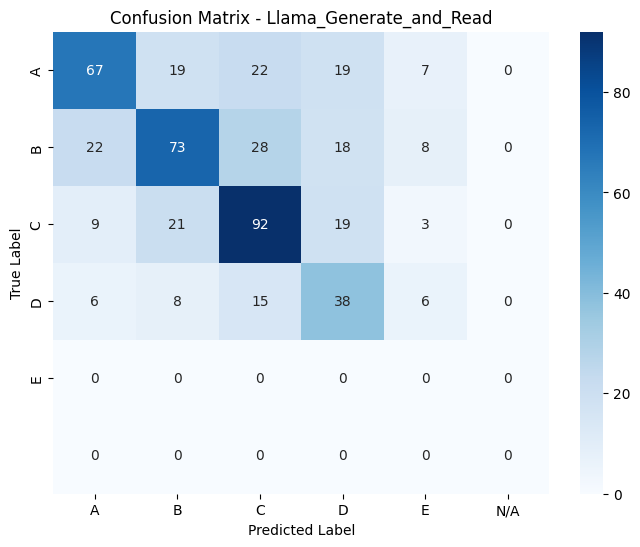

In [ ]:
# Calcolo metriche
metrics = compute_metrics(
    y_true=y_true,
    y_pred=y_pred,
    label_name="Llama_Generate_and_Read"
)

In [ ]:
columns = ['custom_id',	'question', 'reasoning',	'prediction',	'confidence',	'correct_answer',	'all_probs']

file_path = f"{PATH}/results/llama_G&R.json"
df_results[columns].to_json(file_path, orient='records', indent=4, force_ascii=False)
print(f"Risultati salvati in: {file_path}")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/llama_G&R.json


### Steering

In [ ]:
class SteeringController:
    def __init__(self, model, tokenizer, layer_idx=15):
        self.model = model
        self.tokenizer = tokenizer
        self.layer_idx = layer_idx
        self.steering_vector = None
        self.handle = None
        self.multiplier = 1.0 # Forza dello steering

    def create_steering_vector(self, pos_texts, neg_texts):
        """Calcola il vettore differenza tra attivazioni positive e negative."""
        pos_acts = self._get_hidden_states(pos_texts)
        neg_acts = self._get_hidden_states(neg_texts)

        # Il vettore è la differenza media tra le attivazioni
        self.steering_vector = pos_acts.mean(dim=0) - neg_acts.mean(dim=0)
        print(f"✅ Vettore di steering creato per il layer {self.layer_idx}")

    def _get_hidden_states(self, texts):
        """Estrae le attivazioni dal layer specificato."""
        all_acts = []
        for text in texts:
            inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)
            with torch.no_grad():
                outputs = self.model(**inputs, output_hidden_states=True)
                # Prendiamo l'attivazione dell'ultimo token nell'ultimo layer scelto
                # hidden_states è una tupla (uno per ogni layer)
                act = outputs.hidden_states[self.layer_idx][0, -1, :]
                all_acts.append(act)
        return torch.stack(all_acts)

    def _steering_hook(self, module, input, output):
        """Funzione che modifica le attivazioni durante il forward pass."""
        if self.steering_vector is not None:
            # L'output dei layer di Llama/Mistral è solitamente una tupla (hidden_states, cache)
            if isinstance(output, tuple):
                h_state = output[0]
                # Sommiamo il vettore a ogni token nella sequenza corrente
                # h_state shape: [batch, seq_len, hidden_dim]
                modified_h = h_state + (self.multiplier * self.steering_vector)
                return (modified_h,) + output[1:]
            else:
                return output + (self.multiplier * self.steering_vector)
        return output

    def apply(self, multiplier=1.0):
        """Attiva lo steering sul modello."""
        self.multiplier = multiplier
        # Cerchiamo il layer specifico nel modello (valido per Llama e Mistral)
        target_layer = self.model.model.layers[self.layer_idx]
        self.handle = target_layer.register_forward_hook(self._steering_hook)
        print(f"🚀 Steering attivato (multiplier={multiplier})")

    def remove(self):
        """Rimuove lo steering e ripristina il comportamento originale."""
        if self.handle:
            self.handle.remove()
            print("Steering rimosso.")

In [ ]:
# 1. Inizializzazione
# Scegliamo un layer centrale (es. 16 su 32), dove risiede la semantica
controller = SteeringController(model, tokenizer, layer_idx=16)

# 2. Creazione del vettore (Dataset di contrasto)
pos_examples = [
    "Analisi finanziaria rigorosa, calcoli precisi, focus su indici macroeconomici.",
    "Esperto di mercati, logica deduttiva, precisione numerica, terminologia tecnica."
]
neg_examples = [
    "Parlato generico, opinioni vaghe, mancanza di dati, linguaggio colloquiale.",
    "Risposta approssimativa, testo discorsivo senza analisi dei numeri."
]
controller.create_steering_vector(pos_examples, neg_examples)



✅ Vettore di steering creato per il layer 16


In [ ]:
# 3. Esecuzione con Steering
def run_steered_inference(df, controller):
    # Attiviamo lo "sterzo" prima di generare il ragionamento
    controller.apply(multiplier=1.2) # 1.2 è un buon punto di partenza

    # Qui chiami la tua funzione originale o una variante
    results_df = run_generate_and_read(df, model, tokenizer)

    # Importante: rimuovere sempre alla fine
    controller.remove()
    return results_df


In [ ]:
# Esegui l'esperimento
df_steered = run_steered_inference(validation_data, controller)

🚀 Steering attivato (multiplier=1.2)


Inference G&R: 100%|██████████| 500/500 [3:07:26<00:00, 22.49s/it]

Steering rimosso.


In [ ]:
df_steered.head()

,custom_id,question,reasoning,prediction,confidence,correct_answer,all_probs
0,BOOKS__1646,1. Il committente massimizza i propri profitti...,1. Il committente massimizza i propri profitti...,D,0.295898,B,"{'A': 0.059173583984375, 'B': 0.27783203125, '..."
1,PAPER__3536,1. Il sistema bancario ombra è un tipo di sist...,1. Il sistema bancario ombra è un tipo di sist...,D,0.460938,C,"{'A': 0.207763671875, 'B': 0.1077880859375, 'C..."
2,PAPER__3297,1. Esiste un equilibrio competitivo se ogni in...,1. L'equilibrio competitivo è un concetto fond...,D,0.456299,C,"{'A': 0.06890869140625, 'B': 0.2442626953125, ..."
3,BOOKS__5422,Cosa descrive meglio la caratteristica princip...,Concorrenza di Bertrand.\n\nPer comprendere la...,C,0.928711,C,"{'A': 0.01081085205078125, 'B': 0.005187988281..."
4,PAPER__2502,1. La misura ∆CoVaR rileva la variazione del v...,1. La misura ∆CoVaR rileva la variazione del v...,D,0.798828,D,"{'A': 0.0645751953125, 'B': 0.030975341796875,..."


In [ ]:
# 2. Preparazione dei dati per le funzioni successive
# Estraiamo le liste necessarie per compute_metrics e save_results
y_true = df_steered['correct_answer'].tolist()
y_pred = df_steered['prediction'].tolist()
# Per G&R, la "raw_response" è il ragionamento prodotto nello Step 1
raw_reasons = df_steered['reasoning'].tolist()


📊 METRICHE PER: Llama_Steering
Accuracy:   47.40%
F1-Score:   0.3810 (Macro)
Fail Ratio: 0.00% (0/500 risposte non valide)
------------------------------


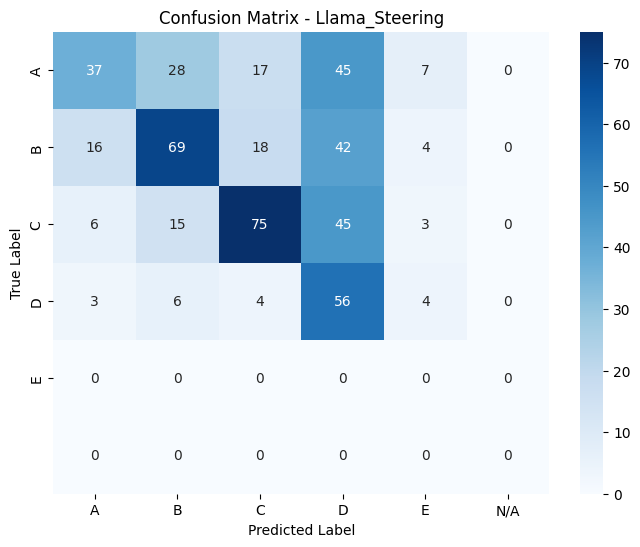

In [ ]:
# Calcolo metriche
metrics = compute_metrics(
    y_true=y_true,
    y_pred=y_pred,
    label_name="Llama_Steering"
)

In [ ]:
columns = ['custom_id',	'question', 'reasoning',	'prediction',	'confidence',	'correct_answer',	'all_probs']

file_path = f"{PATH}/results/llama_steering.json"
df_steered[columns].to_json(file_path, orient='records', indent=4, force_ascii=False)
print(f"Risultati salvati in: {file_path}")

Risultati salvati in: /content/drive/MyDrive/University/BigData/Project/results/llama_steering.json


## Multiple-answer generation with selection of a single best response

In [ ]:
def load_and_prepare_data(folder="results", model_name="mistral"):
    # Carichiamo i tre file salvati in precedenza
    path_zs = f"{PATH}/{folder}/{model_name}_zero_shot.json"
    path_fs = f"{PATH}/{folder}/{model_name}_few_shot.json"
    path_cot = f"{PATH}/{folder}/{model_name}_cot_shot.json"

    df_zs = pd.read_json(path_zs)
    df_fs = pd.read_json(path_fs)
    df_cot = pd.read_json(path_cot)

    # Rinominiamo le colonne 'raw_responses' per non farle sovrapporre durante il merge
    df_zs = df_zs.rename(columns={'raw_responses': 'resp_zs', 'prediction': 'pred_zs'})
    df_fs = df_fs.rename(columns={'raw_responses': 'resp_fs', 'prediction': 'pred_fs'})
    df_cot = df_cot.rename(columns={'raw_responses': 'resp_cot', 'prediction': 'pred_cot'})

    # Uniamo i dataframe sulla colonna 'custom_id' (o 'question' se non hai ID univoci)
    merged_df = pd.merge(df_zs, df_fs[['custom_id', 'resp_fs', 'pred_fs']], on='custom_id')
    merged_df = pd.merge(merged_df, df_cot[['custom_id', 'resp_cot', 'pred_cot']], on='custom_id')

    return merged_df

In [ ]:
def prepare_judge_prompts(df, tokenizer):
    """
    Prepara la lista di prompt formattati per il modello giudice.
    """
    formatted_prompts = []

    system_msg = (
        "Sei un Arbitro Esperto in Finanza. Il tuo compito è analizzare 3 diverse analisi "
        "e selezionare la risposta corretta (A, B, C, D o E) basandoti sul ragionamento più solido."
    )

    for _, row in df.iterrows():
        user_msg = f"""DOMANDA: {row['question']}

OPZIONI:
A) {row.get('choiceA', '')}
B) {row.get('choiceB', '')}
C) {row.get('choiceC', '')}
D) {row.get('choiceD', '')}
E) {row.get('choiceE', '')}

ANALISI DA VALUTARE:
1. (Zero-Shot): {row['resp_zs']}
2. (Few-Shot): {row['resp_fs']}
3. (CoT): {row['resp_cot']}

VALUTAZIONE:
1. Confronta i dati numerici.
2. Identifica errori logici.
3. Decidi la lettera corretta.

RISPONDI SEMPRE NEL SEGUENTE FORMATO:
MOTIVAZIONE: [Breve spiegazione]
RISPOSTA FINALE: [Lettera]"""

        messages = [
            {"role": "system", "content": system_msg},
            {"role": "user", "content": user_msg}
        ]

        # Applichiamo il template ufficiale di Llama-3.1
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        formatted_prompts.append(prompt)

    return formatted_prompts


In [ ]:
def run_judge_inference(model, tokenizer, prompts, batch_size=4):
    """
    Esegue l'inferenza batch per il giudice.
    """
    all_decisions = []
    model.eval()

    for i in range(0, len(prompts), batch_size):
        batch = prompts[i : i + batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096 # Più lungo perché include 3 analisi
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=250,
                do_sample=False, # Greedy per massima consistenza
                temperature=0.0,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id
            )

        for j, output_sequence in enumerate(outputs):
            # Decodifica solo la parte generata (escludendo il prompt)
            generated_text = tokenizer.decode(
                output_sequence[inputs['input_ids'][j].shape[0]:],
                skip_special_tokens=True
            ).strip()
            all_decisions.append(generated_text)

    return all_decisions

In [ ]:
# --- ESECUZIONE ---

# 1. Carica i dati dai JSON precedenti
merged_results = load_and_prepare_data()

In [ ]:
# 2. Inizializza le liste per i nuovi risultati
final_preds = []
judge_motivations = []

print(f"Inizio arbitraggio su {len(merged_results)} record...")

# Esecuzione
judge_prompts = prepare_judge_prompts(merged_results, tokenizer_llama)
raw_judgments = run_judge_inference(model_llama, tokenizer_llama, judge_prompts)

# Estrazione finale
final_predictions = []
for text in raw_judgments:
    match = re.search(r"RISPOSTA FINALE:\s*([A-E])", text.upper())
    final_predictions.append(match.group(1) if match else "N/A")

merged_results['judge_explanation'] = raw_judgments
merged_results['judge_prediction'] = final_predictions

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Inizio arbitraggio su 500 record...


In [ ]:
# 4. Calcola l'accuratezza per vedere se il Giudice ha fatto meglio dei singoli
acc_zs = (merged_results['correct_answer'] == merged_results['pred_zs']).mean()
acc_fs = (merged_results['correct_answer'] == merged_results['pred_fs']).mean()
acc_cot = (merged_results['correct_answer'] == merged_results['pred_cot']).mean()
acc_judge = (merged_results['correct_answer'] == merged_results['judge_prediction']).mean()

print(f"\n--- PERFORMANCE COMPARISON ---")
print(f"Accuracy Zero-Shot: {acc_zs:.2%}")
print(f"Accuracy Few-Shot:  {acc_fs:.2%}")
print(f"Accuracy CoT:       {acc_cot:.2%}")
print(f"Accuracy GIUDICE:   {acc_judge:.2%}")


--- PERFORMANCE COMPARISON ---
Accuracy Zero-Shot: 38.80%
Accuracy Few-Shot:  25.40%
Accuracy CoT:       40.00%
Accuracy GIUDICE:   38.00%


In [ ]:
# 5. Salva il dataset finale "arbitrato"
output_path = f"{PATH}/results/mistral_FINAL_JUDGED.json"
merged_results.to_json(output_path, orient='records', indent=4, force_ascii=False)
print(f"\nRisultati finali salvati in: {output_path}")


Risultati finali salvati in: /content/drive/MyDrive/University/BigData/Project/results/mistral_FINAL_JUDGED.json



📊 METRICHE PER: Llama as Judge
Accuracy:   38.00%
F1-Score:   0.3226 (Macro)
Fail Ratio: 7.80% (39/500 risposte non valide)
------------------------------


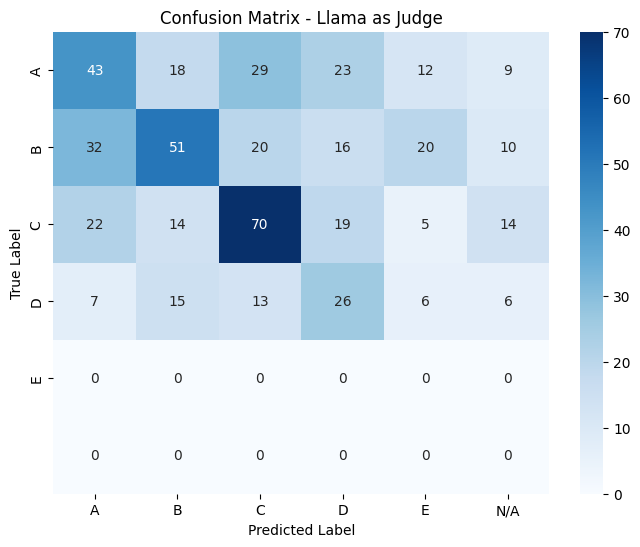

{'accuracy': 0.38,
 'f1': 0.32255131425931344,
 'fail_ratio': 0.078,
 'confusion_matrix': array([[43, 18, 29, 23, 12,  9],
        [32, 51, 20, 16, 20, 10],
        [22, 14, 70, 19,  5, 14],
        [ 7, 15, 13, 26,  6,  6],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]])}

In [ ]:
mistral_metrics = compute_metrics(y_true_val, final_predictions, 'Llama as Judge')
mistral_metrics

## Agentic Behavior and Retrieval

In [ ]:
!pip install langchain-community tavily-python -q
!pip install -U langchain-community duckduckgo-search -q
!pip install -U ddgs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
from typing import TypedDict, Literal, Optional, List
import os
from google.colab import userdata


from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
import os
from tqdm import tqdm


# LangChain & LangGraph imports
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import numpy as np
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings

from typing import TypedDict, List, Optional
import re
import pandas as pd

from typing import TypedDict, List, Optional
from typing import TypedDict, List, Optional
import re
import pandas as pd

from typing import TypedDict, List, Optional


from langchain_community.tools import DuckDuckGoSearchRun


BASE_DIR = "/content/drive/MyDrive/University/BigData/Project/agentic"
os.makedirs(BASE_DIR, exist_ok=True)


#os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

#web_search_tool = TavilySearchResults(k=3)

ddg_search = DuckDuckGoSearchRun()

#Wrapper per configurare il numero di risultati
#wrapper = DuckDuckGoSearchAPIWrapper(max_results=3)
#web_search_tool = DuckDuckGoSearchResults(api_wrapper=wrapper)


In [ ]:
embeddings_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

class SemanticRAGCache:
    def __init__(self, embeddings_model, threshold=0.3):
        self.embeddings = embeddings_model
        self.threshold = threshold
        self.vector_db = None
        self.filename = os.path.join(BASE_DIR, "semantic_cache_faiss")

        # Prova a caricare la cache esistente
        if os.path.exists(self.filename):
            self.vector_db = FAISS.load_local(self.filename, self.embeddings, allow_dangerous_deserialization=True)

    def get(self, query):
        if self.vector_db is None:
            return None

        # Cerca la domanda più simile (k=1)
        # score è la distanza: più è basso, più sono simili
        results = self.vector_db.similarity_search_with_score(query, k=1)

        if results:
            doc, score = results[0]
            if score < self.threshold:
                print(f"🎯 [SEMANTIC CACHE HIT] Score: {score:.4f}")
                return doc.page_content
        return None

    def set(self, query, results):
        new_doc = Document(page_content=results, metadata={"query": query})

        if self.vector_db is None:
            self.vector_db = FAISS.from_documents([new_doc], self.embeddings)
        else:
            self.vector_db.add_documents([new_doc])

        # Salva localmente
        self.vector_db.save_local(self.filename)

rag_cache = SemanticRAGCache(embeddings_model)

In [ ]:
VERIFY_PROMPT_TEMPLATE = [
    {
        'role': 'system',
        'content': 'Sei un analista finanziario esperto nella verifica della coerenza logica e tecnica.'
    },
    {
        'role': 'user',
        'content': """Esamina criticamente le opzioni fornite per la seguente domanda.

        DOMANDA: {question}
        OPZIONI: A) {choiceA}, B) {choiceB}, C) {choiceC}, D) {choiceD}, E) {choiceE}

        Analizza la validità tecnica di ciascuna opzione rispetto ai principi finanziari.
        Evidenzia eventuali errori concettuali o punti di forza, fornendo una valutazione complessiva della loro coerenza senza indicare esplicitamente la risposta corretta.

        Analisi:"""
    }
]

VERIFY_RAG_PROMPT_TEMPLATE = [
    {
        "role": "system",
        "content": "Sei un analista finanziario. Valuti la coerenza delle opzioni usando esclusivamente i dati forniti."
    },
    {
        "role": "user",
        "content": """

        DOMANDA: {question}
        OPZIONI: A: {choiceA}, B: {choiceB}, C: {choiceC}, D: {choiceD}, E: {choiceE}

        CONTESTO (dati recuperati):
        {context}

        Compito:
        - Verifica se una o più opzioni sono chiaramente supportate o contraddette dal contesto.
        - Segnala solo incongruenze evidenti o affermazioni non supportate.
        - Se il contesto non è sufficiente, indicalo esplicitamente.

        Rispondi in modo sintetico, senza analizzare ogni opzione separatamente e senza indicare la risposta corretta.

        Valutazione:"""
            }
    ]


REASONING_PROMPT_TEMPLATE = [
    {
        'role': 'system',
        'content': 'Sei un analista finanziario senior Il tuo compito è scegliere la risposta corretta basandoti sui dati forniti.'
    },
    {
        'role': 'user',
        'content': """Risolvi la domanda finanziaria usando il Contesto RAG e l'Analisi Logica.

        DOMANDA: {question}
        OPZIONI: A: {choiceA}, B: {choiceB}, C: {choiceC}, D: {choiceD}, E: {choiceE}

        [DATI RECUPERATI (RETRIEVAL)]:
        {context}

        [ANALISI LOGICA (VERIFICA)]:
        {verify} (Nota: Se N/A, procedi solo con i dati del retrieval)

        Rispondi indicando solo la lettera della risposta corretta (A, B, C, D o E) senza aggiungere spiegazioni.
        Risposta:"""
    }
]


In [ ]:
def prepare_prompt_agent(row_dict, prompt_template, tokenizer, extra_fields=None):
    """
    Versione 'single-row' di prepare_prompts coerente con il tuo codice originale.
    """
    user_content_template = prompt_template[1]['content']

    # Uniamo i dati della riga con eventuali campi extra (context, check)
    format_data = {**row_dict}
    if extra_fields:
        format_data.update(extra_fields)

    # Formattazione del testo dell'utente
    user_content = user_content_template.format(**format_data)

    current_prompt = [
        prompt_template[0],
        {'role': 'user', 'content': user_content}
    ]

    # Applichiamo il chat template (come in prepare_prompts)
    return tokenizer.apply_chat_template(
        current_prompt,
        tokenize=False,
        add_generation_prompt=True
    )

def generate_response_agent(formatted_prompt, model, tokenizer):
    """Invocazione del modello coerente con generate_responses."""
    inputs = tokenizer([formatted_prompt], return_tensors="pt", padding=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False,        # Se do_sample è False, non serve temperature
            temperature=None,       # Rimuove il warning
            top_p=None,             # Rimuove il warning
            pad_token_id=tokenizer.eos_token_id # Forza il pad corretto
        )
    # Decodifica saltando il prompt (come nel tuo codice originale)
    start_idx = inputs['input_ids'][0].shape[0]
    generated_text= tokenizer.decode(outputs[0][start_idx:], skip_special_tokens=True).strip()
    return generated_text

In [ ]:
import collections

class AgentState(TypedDict):
    question_data: dict
    model: AutoModelForCausalLM
    tokenizer: AutoTokenizer
    retrieved_info: Optional[str]
    verification_info: Optional[str]
    decision: str
    final_choice: Optional[str]
    raw_response: Optional[str]

# Nodo 1: Decisione Strategica
def decide_strategy(state: AgentState):
    q = state["question_data"]
    complexity = str(q.get("difficulty_level", "medium")).lower()

    if complexity == 'easy':
        # Salta retrieval e verifica, vai dritto alla risposta
        return {"decision": "skip_to_answer"}
    elif complexity == 'medium':
        return {"decision": "retrieve_only"}
    return {"decision": "retrieve_and_verify"}

# Nodo 2: Retrieval (Web Search)
"""def retrieval_node(state: AgentState):
    # Inizializziamo sempre la variabile all'inizio per evitare NameError
    full_query = state["question_data"]["question"]
    search_query = full_query[:500] # Limite ragionevole per evitare errori HTTP

    # 1. Controllo Cache
    cached_content = ddg_search.get(search_query)
    if cached_content:
        print(f"📦 [CACHE HIT]")
        return {"retrieved_info": cached_content}

    print(f"🌐 [CACHE MISS] Ricerca per: {search_query[:50]}...")

    try:
        # Invocazione dello strumento
        search_results = web_search_tool.invoke(search_query)
        context = str(search_results)

        # Salvataggio in cache
        rag_cache.set(search_query, context)
        return {"retrieved_info": context}

    except Exception as e:
        # Qui search_query esiste sicuramente perché definita alla riga 3
        print(f"⚠️ Errore durante la ricerca per '{search_query[:30]}': {e}")
        return {"retrieved_info": "N/A - Errore nella ricerca"}"""


def retrieval_node(state: AgentState):
    # 1. Preparazione Query
    full_query = state["question_data"]["question"]
    search_query = full_query[:300]

    # 2. Controllo Cache Semantica (FAISS)
    # Se una domanda simile è stata già cercata, restituiamo il risultato
    cached_content = rag_cache.get(full_query)
    if cached_content:
        return {"retrieved_info": cached_content, "log": ["🎯 Semantic Cache Hit"]}

    print(f"🦆 Ricerca DuckDuckGo in corso...")

    try:
        # 3. Esecuzione Ricerca (Restituisce gli snippet dei primi risultati)
        # DuckDuckGoSearchRun aggrega i titoli e i riassunti in un'unica stringa
        context = ddg_search.run(search_query)

        if not context or len(context) < 20:
            return {"retrieved_info": "N/A - Nessun risultato trovato su DuckDuckGo."}

        # 4. Pulizia e Limite caratteri
        # Tagliamo a 3000 caratteri per mantenere il prompt pulito per Mistral
        final_context = context.strip()[:3000]

        # 5. Salvataggio in Cache Semantica
        # Salviamo la stringa degli snippet nel database vettoriale
        rag_cache.set(full_query, final_context)

        print(f"✅ Recuperati dati da DuckDuckGo")
        return {"retrieved_info": final_context}

    except Exception as e:
        print(f"❌ Errore DuckDuckGo: {e}")
        return {"retrieved_info": "N/A - Errore tecnico durante il retrieval."}



# Nodo 3: Verifica Logica
"""def verify_node(state: AgentState):
    row = state["question_data"]
    formatted_prompt = prepare_prompt_agent(row, VERIFY_PROMPT_TEMPLATE, state["tokenizer"])
    response = generate_response_agent(formatted_prompt, state["model"], state["tokenizer"])
    return {"verification_info": response}"""

def verify_node(state: AgentState):
    row = state["question_data"]
    # Recuperiamo il contesto trovato da DuckDuckGo
    context = state.get("retrieved_info", "N/A")

    # Prepariamo il prompt includendo esplicitamente il contesto
    extra = {"context": context}
    formatted_prompt = prepare_prompt_agent(row, VERIFY_RAG_PROMPT_TEMPLATE, state["tokenizer"], extra_fields=extra)

    # Generazione veloce (max 250 token)
    response = generate_response_agent(formatted_prompt, state["model"], state["tokenizer"])

    print("⚖️ Verifica comparativa post-RAG completata.")
    return {"verification_info": response}

# Nodo 4: Ragionamento Finale
def reasoning_node(state: AgentState):
    row = state["question_data"]
    extra = {
      "context": state.get("retrieved_info", "N/A"),
      "verify": state.get("verification_info", "N/A")
    }
    formatted_prompt = prepare_prompt_agent(row, REASONING_PROMPT_TEMPLATE, state["tokenizer"], extra_fields=extra)
    raw_response = generate_response_agent(formatted_prompt, state["model"], state["tokenizer"])

    final_letter = process_response(raw_response)
    return {
        "final_choice": final_letter,
        "raw_response": raw_response,
    }





In [ ]:
# --- RICOSTRUZIONE DEL GRAFO CORRETTA ---

"""workflow = StateGraph(AgentState)

workflow.add_node("decide", decide_strategy)
workflow.add_node("retrieve", retrieval_node)
workflow.add_node("verify", verify_node)
workflow.add_node("answer", reasoning_node)

# Punto di ingresso
workflow.set_entry_point("decide")

# 1. Collegamenti condizionali dopo DECIDE
workflow.add_conditional_edges(
    "decide",
    lambda s: s["decision"],
    {
        "skip_to_answer": "answer",       # Easy: vai dritto alla risposta
        "retrieve_only": "retrieve",      # Medium: vai a cercare sul web
        "retrieve_and_verify": "retrieve" # Hard: vai a cercare sul web
    }
)

# 2. Collegamenti condizionali dopo RETRIEVE
# Dobbiamo controllare se dopo il retrieval dobbiamo andare a Verify (Hard) o Answer (Medium)
workflow.add_conditional_edges(
    "retrieve",
    lambda s: s["decision"],
    {
        "retrieve_only": "answer",
        "retrieve_and_verify": "verify"
    }
)

# 3. Collegamenti semplici
workflow.add_edge("verify", "answer")
workflow.add_edge("answer", END)

agent_app = workflow.compile()"""

workflow = StateGraph(AgentState)

workflow.add_node("decide", decide_strategy)
workflow.add_node("retrieve", retrieval_node)
workflow.add_node("verify", verify_node) # Ora questo nodo "legge" i dati del retrieval
workflow.add_node("answer", reasoning_node)

workflow.set_entry_point("decide")

# 1. Dopo DECIDE
workflow.add_conditional_edges(
    "decide",
    lambda s: s["decision"],
    {
        "skip_to_answer": "answer",       # Casi facili: vai dritto alla fine
        "retrieve_only": "retrieve",      # Casi medi: cerca e poi rispondi
        "retrieve_and_verify": "retrieve" # Casi difficili: cerca, confronta e rispondi
    }
)

# 2. Dopo RETRIEVE (Il bivio intelligente)
workflow.add_conditional_edges(
    "retrieve",
    lambda s: s["decision"],
    {
        "retrieve_only": "answer",        # Salta la verifica se complexity = medium
        "retrieve_and_verify": "verify"   # Vai alla verifica se complexity = hard
    }
)

# 3. Chiusura del cerchio
workflow.add_edge("verify", "answer")
workflow.add_edge("answer", END)

agent_app = workflow.compile()



In [ ]:
def run_agentic(df, model, tokenizer):
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Esecuzione Benchmark Agentico"):
        row_dict = row.to_dict()

        initial_state = {
            "question_data": row_dict,
            "model": model,
            "tokenizer": tokenizer,
            "retrieved_info": None,
            #verification_info": None,"""
            "decision": "",
            "final_choice": None,
            "raw_response": None
        }

        try:
            # ESECUZIONE DEL GRAFO
            output = agent_app.invoke(initial_state)

            # Estrazione sicura con fallback
            pred = output.get("final_choice", "N/A")
            #v_info = output.get("verification_info", "N/A")
            c_rag = output.get("retrieved_info", "N/A")
            raw_r = output.get("raw_response", "N/A")

            # Arricchimento del dizionario originale
            row_dict["predicted"] = pred
            row_dict["agent_path"] = output.get("decision", "direct")
            #row_dict["agent_verification"] = v_info
            row_dict["agent_context_rag"] = c_rag
            row_dict["raw_response"] = raw_r
            row_dict["is_correct"] = 1 if str(pred).strip().upper() == str(row.get('correct_answer')).strip().upper() else 0

            results.append(row_dict)

        except Exception as e:
            print(f"Errore alla riga {idx}: {e}")
            gc.collect()
            torch.cuda.empty_cache()

            row_dict["predicted"] = "ERR"
            row_dict["is_correct"] = 0
            row_dict["agent_path"] = "ERROR"
            results.append(row_dict)

    # Restituiamo solo il DataFrame. Le predizioni sono già dentro!
    return pd.DataFrame(results)

In [ ]:
def save_results_agent(df, technique_name="agentic", model_name="mistral", folder="results"):
    # Percorso assoluto completo
    target_dir = os.path.join(BASE_DIR, folder)

    # Crea la cartella se non esiste (incluso il path genitore se necessario)
    if not os.path.exists(target_dir):
        os.makedirs(target_dir, exist_ok=True)
        print(f"📁 Creata cartella: {target_dir}")

    file_name = f"{model_name}_{technique_name}.json"
    file_path = os.path.join(target_dir, file_name)

    # Salvataggio
    df.to_json(file_path, orient='records', indent=4, force_ascii=False)
    print(f"💾 Risultati salvati correttamente in: {file_path}")
    return file_path

### MIstral

In [ ]:
agent_config = {
    "chunk_size": 800,
    "chunk_overlap": 50,
    "retrieval_k": 3,
    "temperature": 0.7,
    "llm_model_name": model_card_mistral # Save the model card string instead of the object
}

import json
with open(os.path.join(BASE_DIR, "agent_config.json"), "w") as f:
    json.dump(agent_config, f, indent=2)
print("Config agente salvata")

In [ ]:
df_res = run_agentic(validation_data, model_mistral, tokenizer_mistral) # Sample 3 questions for testing, added random_state for reproducibility


results_path = save_results_agent(df_res, technique_name="agentic", model_name="mistral")

# Extract correct answers from the df_res (which is a sample of validation_data)
y_true_agentic_sample = df_res['correct_answer'].tolist()
predicted_agentic = df_res['predicted'].tolist()

mistral_metrics = compute_metrics(y_true_agentic_sample, predicted_agentic, 'Mistral Agentic') # Changed label for clarity
mistral_metrics

Esecuzione Benchmark Agentico:   0%|          | 0/500 [00:00<?, ?it/s]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   0%|          | 1/500 [00:02<23:44,  2.86s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   0%|          | 2/500 [01:15<6:05:54, 44.08s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   1%|          | 3/500 [01:17<3:25:53, 24.86s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   1%|          | 4/500 [01:23<2:24:10, 17.44s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   1%|          | 5/500 [02:51<5:53:19, 42.83s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   1%|          | 6/500 [03:52<6:44:16, 49.10s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   1%|▏         | 7/500 [03:55<4:37:19, 33.75s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   2%|▏         | 8/500 [04:41<5:09:21, 37.73s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   2%|▏         | 8/500 [05:17<5:24:57, 39.63s/it]


KeyboardInterrupt: 

In [ ]:
df_res

,custom_id,category,question,choiceA,choiceB,choiceC,choiceD,choiceE,correct_answer,difficulty_level,language,predicted,agent_path,agent_verification,agent_context_rag,raw_response,is_correct
0,BOOKS__2023,BOOKS,1. Gli individui compiono ogni giorno scelte e...,"1, 2, 3, 4","2, 3","2, 3, 5","1, 3, 4",Nessuna delle precedenti,D,easy,IT,D,skip_to_answer,None,None,"D: 1, 3, 4",1
1,PAPER__3190,PAPER,Qual è la caratteristica distintiva di una cri...,Il sistema bancario può facilmente soddisfare ...,Gli istituti finanziari sono eccessivamente li...,Il sistema bancario diventa incapace di onorar...,I depositanti dimostrano fiducia nel sistema b...,Nessuna delle precedenti,C,medium,IT,C,retrieve_only,None,La frode è stata anche la causa di numerosi gr...,C: Il sistema bancario diventa incapace di ono...,1
2,FINANCIALS__3767,FINANCIALS,Considerando tutte le variazioni delle attivit...,Miglioramento del patrimonio netto e delle pas...,Miglioramento dei rapporti tra patrimonio nett...,"Deterioramento delle attività differite, compe...",Aumento dei debiti a breve termine superiore a...,Nessuna delle precedenti,B,medium,IT,B,retrieve_only,None,La redazione dell' inventario di magazzino a f...,B: Miglioramento dei rapporti tra patrimonio n...,1


### Llama

In [ ]:
agent_config = {
    "chunk_size": 800,
    "chunk_overlap": 50,
    "retrieval_k": 3,
    "temperature": 0.7,
    "llm_model_name": model_card_llama # Save the model card string instead of the object
}

import json
with open(os.path.join(BASE_DIR, "agent_config_llama.json"), "w") as f:
    json.dump(agent_config, f, indent=2)
print("Config agente salvata")

KeyboardInterrupt: 

In [ ]:
# Hugging Face
!rm -rf /root/.cache/huggingface

# Pip
!rm -rf /root/.cache/pip

# Apt
!apt-get clean
!rm -rf /var/lib/apt/lists/*


In [ ]:
df_res = run_agentic(validation_data, model_llama, tokenizer_llama) # Sample 3 questions for testing, added random_state for reproducibility


results_path = save_results_agent(df_res, technique_name="agentic_double_check", model_name="llama")

# Extract correct answers from the df_res (which is a sample of validation_data)
y_true_agentic_sample = df_res['correct_answer'].tolist()
predicted_agentic = df_res['predicted'].tolist()

llama_metrics = compute_metrics(y_true_agentic_sample, predicted_agentic, 'Mistral llama') # Changed label for clarity
llama_metrics

Esecuzione Benchmark Agentico:   0%|          | 0/500 [00:00<?, ?it/s]

🦆 Ricerca DuckDuckGo in corso...


The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   0%|          | 1/500 [01:28<12:12:04, 88.03s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   0%|          | 2/500 [01:59<7:35:53, 54.93s/it] 

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   1%|          | 3/500 [02:31<6:06:59, 44.31s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   1%|          | 4/500 [03:31<6:59:10, 50.71s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   1%|          | 5/500 [05:09<9:17:30, 67.58s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   1%|          | 6/500 [06:37<10:13:05, 74.46s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   1%|▏         | 7/500 [08:13<11:11:28, 81.72s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   2%|▏         | 8/500 [09:37<11:14:50, 82.30s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   2%|▏         | 9/500 [11:14<11:50:38, 86.84s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   2%|▏         | 10/500 [11:34<9:01:57, 66.36s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   2%|▏         | 11/500 [12:08<7:38:57, 56.31s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   2%|▏         | 12/500 [12:43<6:45:39, 49.88s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   3%|▎         | 13/500 [13:13<5:56:56, 43.98s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   3%|▎         | 14/500 [13:40<5:13:12, 38.67s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   3%|▎         | 15/500 [13:54<4:12:13, 31.20s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   3%|▎         | 17/500 [15:38<5:14:18, 39.04s/it]

Errore alla riga 16: argument of type 'NoneType' is not iterable


Esecuzione Benchmark Agentico:   4%|▎         | 18/500 [15:58<4:28:06, 33.37s/it]

Errore alla riga 17: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   4%|▍         | 19/500 [16:34<4:35:02, 34.31s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   4%|▍         | 20/500 [17:04<4:22:20, 32.79s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:   4%|▍         | 21/500 [17:14<3:27:57, 26.05s/it]

Errore alla riga 20: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   4%|▍         | 22/500 [17:46<3:41:17, 27.78s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:   5%|▍         | 23/500 [18:17<3:48:34, 28.75s/it]

Errore alla riga 22: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   5%|▍         | 24/500 [18:37<3:27:57, 26.21s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:   5%|▌         | 25/500 [18:46<2:46:28, 21.03s/it]

Errore alla riga 24: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   5%|▌         | 26/500 [19:11<2:55:55, 22.27s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   5%|▌         | 27/500 [19:44<3:21:04, 25.51s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   6%|▌         | 28/500 [20:21<3:46:57, 28.85s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   6%|▌         | 29/500 [20:47<3:39:24, 27.95s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   6%|▌         | 30/500 [22:22<6:17:19, 48.17s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   6%|▌         | 31/500 [22:55<5:40:30, 43.56s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   6%|▋         | 32/500 [23:12<4:37:52, 35.62s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   7%|▋         | 33/500 [23:43<4:26:08, 34.19s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   7%|▋         | 34/500 [25:26<7:06:31, 54.92s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   7%|▋         | 35/500 [26:52<8:18:20, 64.30s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   7%|▋         | 36/500 [27:25<7:03:48, 54.80s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:   7%|▋         | 37/500 [27:51<5:55:26, 46.06s/it]

Errore alla riga 36: argument of type 'NoneType' is not iterable


Esecuzione Benchmark Agentico:   8%|▊         | 38/500 [28:00<4:28:27, 34.87s/it]

Errore alla riga 37: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   8%|▊         | 39/500 [28:32<4:22:49, 34.21s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   8%|▊         | 40/500 [28:56<3:58:24, 31.10s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   8%|▊         | 41/500 [30:28<6:17:01, 49.29s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   8%|▊         | 42/500 [30:54<5:23:19, 42.36s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:   9%|▊         | 43/500 [31:13<4:30:21, 35.50s/it]

Errore alla riga 42: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:   9%|▉         | 44/500 [32:54<6:58:30, 55.07s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   9%|▉         | 45/500 [33:26<6:04:47, 48.10s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:   9%|▉         | 46/500 [33:39<4:43:09, 37.42s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:   9%|▉         | 47/500 [34:00<4:05:37, 32.53s/it]

Errore alla riga 46: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  10%|▉         | 48/500 [35:36<6:30:23, 51.82s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:  10%|▉         | 49/500 [36:03<5:32:15, 44.20s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  10%|█         | 50/500 [37:17<6:39:43, 53.30s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  10%|█         | 51/500 [38:44<7:53:54, 63.33s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:  10%|█         | 52/500 [39:21<6:52:58, 55.31s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  11%|█         | 53/500 [40:53<8:15:13, 66.47s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:  11%|█         | 54/500 [41:24<6:54:22, 55.75s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:  11%|█         | 55/500 [41:57<6:03:54, 49.07s/it]

⚡ Risposta rapida (Certezza Alta)
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  11%|█         | 56/500 [43:28<7:35:43, 61.58s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  11%|█▏        | 57/500 [44:42<8:01:07, 65.16s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:  12%|█▏        | 58/500 [45:14<6:47:49, 55.36s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:  12%|█▏        | 59/500 [45:30<5:18:44, 43.37s/it]

Errore alla riga 58: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  12%|█▏        | 60/500 [46:52<6:43:10, 54.98s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:  12%|█▏        | 61/500 [47:18<5:39:48, 46.44s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:  12%|█▏        | 62/500 [47:33<4:29:32, 36.92s/it]

Errore alla riga 61: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  13%|█▎        | 64/500 [49:37<5:35:44, 46.20s/it]

Errore alla riga 63: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Esecuzione Benchmark Agentico:  13%|█▎        | 65/500 [50:22<5:31:55, 45.78s/it]

⚡ Risposta rapida (Certezza Alta)


Esecuzione Benchmark Agentico:  13%|█▎        | 66/500 [50:40<4:31:11, 37.49s/it]

Errore alla riga 65: argument of type 'NoneType' is not iterable
🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo
🔄 [DOUBLE CHECK] Rilevata incertezza, genero campioni extra...


Esecuzione Benchmark Agentico:  13%|█▎        | 67/500 [52:15<6:35:28, 54.80s/it]

🦆 Ricerca DuckDuckGo in corso...
✅ Recuperati dati da DuckDuckGo


Accuratezza per easy: 0.32142857142857145
Accuratezza per medium: 0.38642297650130547
Accuratezza per hard: 0.2727272727272727


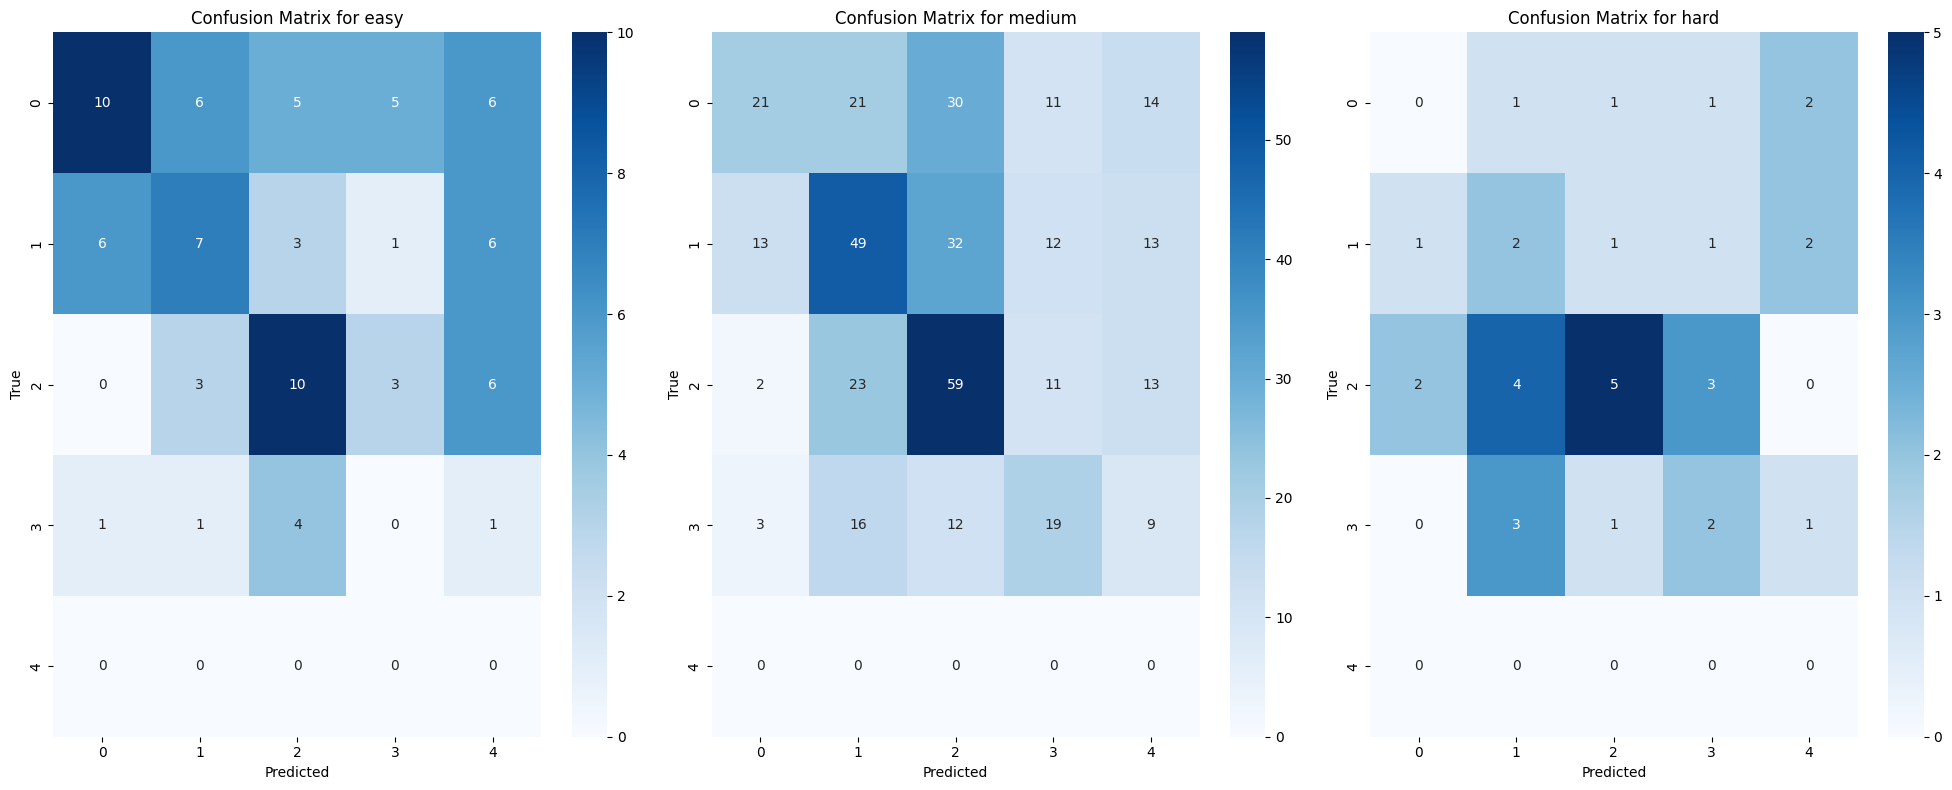

In [ ]:
plt.figure(figsize=(20, 8))

start = 1
difficulty = ['easy', 'medium', 'hard']

for i in difficulty:
    df_res_filtered = df_res[df_res['difficulty_level'] == i]
    y_true = df_res_filtered['correct_answer'].tolist()
    y_pred = df_res_filtered['predicted'].tolist()
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuratezza per {i}: {accuracy}")

    cm = confusion_matrix(y_true, y_pred)

    plt.subplot(1, 3, start)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {i}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    start += 1

plt.tight_layout()
plt.show()


## Compare Results

# Spunti di riflessione:


*   Fine-Tuning con QLoRa andando a splittare noi i dati a disposizione un po' come cazz ci pare

* Usare modelli prettamente Italiani


# Task
Create an interactive GUI using `ipywidgets` to display questions, model predictions, and correct answers from the financial benchmark dataset, allowing for navigation through the questions.

## Implement interactive GUI

### Subtask:
Create an interactive GUI using ipywidgets to display questions, model predictions, correct answers, and allow navigation through questions.


## Summary:

### Q&A
*   **What is the objective of the current subtask?**
    The current subtask aims to create an interactive GUI using `ipywidgets` to display questions, model predictions, and correct answers from the financial benchmark dataset, incorporating navigation functionality.

### Data Analysis Key Findings
*   No data analysis findings are available yet, as the provided solving process only outlines the definition of the subtask and does not include any execution or analytical steps.

### Insights or Next Steps
*   The immediate next step is to proceed with the implementation of the interactive GUI using `ipywidgets` as specified in the subtask definition.
